## Importing Libs

In [154]:
import pandas as pd
import s2sphere
import math
import networkx as nx
from shapely.geometry import box, point
import folium
import random
import numpy as np
from sklearn.neighbors import BallTree, KDTree
import math
from pprint import pprint
import os
from pyhive import hive
from TCLIService.ttypes import TOperationState
import json
import seaborn as sns
import shapefile

## Reading raw data from file.

In [2]:
raw = pd.read_table("../distances_samik_data/latlng.csv", sep=',')

In [3]:
raw.head()

accountid              eventtime   latitude  \
0  ACC7E025D1040AF4AE5864396C9D660CD617  2017-01-05 00:21:33.0  12.918876   
1  ACCC7C2E5E9429847D49DDDDBC7D9DF16382  2017-01-05 00:23:41.0  12.906050   
2  ACCFFC1EB1DBDD04A04A92F51B20C4B28798  2017-01-05 00:56:21.0  12.979481   
3      ACYAZEGXPK5V848J9D4FYEZ3Z83Y9944  2017-01-05 00:56:38.0  12.975563   
4                  ACC13708419899612431  2017-01-05 00:34:13.0  13.014428   

   longitude                 networkidentifier networktype  
0  77.635025  0a5cc3c014ff2454b485bfd43d6d374e        WiFi  
1  77.566644  1f2cdadaf952ec20f6adb53f429b46cd        WiFi  
2  77.638086  7cac746b1ece0a0d2a2575aa7094c41e        WiFi  
3  77.641075  f6f8ca1ed640b8a47a692332d6cd0a19        WiFi  
4  77.666900  f6f8ca1ed640b8a47a692332d6cd0a19     unknown

In [4]:
raw.describe()

latitude     longitude
count  6.944466e+06  6.944466e+06
mean   1.295709e+01  7.762413e+01
std    7.158905e-02  7.135755e-02
min    1.265819e+01  7.732538e+01
25%    1.291501e+01  7.757381e+01
50%    1.295807e+01  7.762153e+01
75%    1.300130e+01  7.767589e+01
max    1.323497e+01  7.783579e+01

In [5]:
raw.describe(include=['O'])

accountid              eventtime  \
count                                6746011                6944466   
unique                                508698                2272091   
top     ACC97D6FC31BD524691ACD2A094124CE3B5O  2016-12-18 16:01:48.0   
freq                                    2023                     57   

                       networkidentifier networktype  
count                            6944466     6944466  
unique                            264546           5  
top     f6f8ca1ed640b8a47a692332d6cd0a19        WiFi  
freq                             1926791     4796079

## Checking for  discrepancies

Ideally each this data is acquired for Wifi network type. But due to potential bugs there are multiple network types with a networkidentifier. Most of these networkidentifier are distributed across Bangalore. We will need to eliminate such rows.

In [6]:
anal_df = raw.groupby('networkidentifier')['networktype'].apply(lambda x: len(x.unique()))
anal_df=anal_df.to_frame()
morethan3unique  = float(anal_df.loc[(anal_df.networktype > 3)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
exactly1unique = float(anal_df.loc[(anal_df.networktype == 1)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
exactly2unique = float(anal_df.loc[(anal_df.networktype == 2)].count())/anal_df.loc[(anal_df.networktype >= 1)].count();
anal_df.loc[(anal_df.networktype == 2)];

## Removal of aforementioned rows.

Ideally, a network identifier should be confined to a small area, but some network identifiers are distributed across the city. 

Will remove these by thresholding the rsme of the distance (in meteres) from the centroid of the points for each networkidentifier.

## Appending the centroid of lat long to the frame.

In [7]:
raw = raw.join(raw.groupby('networkidentifier')['latitude'].mean(), on='networkidentifier', rsuffix='_mean')
raw = raw.join(raw.groupby('networkidentifier')['longitude'].mean(), on='networkidentifier', rsuffix='_mean')

In [8]:
raw = raw.sort_values('networkidentifier')

## Appending the distance from centroid column

Calculating distance by multiplying radius of Earth by arc angle. This works for small distance and erronous for distances beyond cities.

In [9]:
earthRadius = 6371000
def distance_from_center(x):
    center = s2sphere.LatLng.from_degrees(x[6], x[7])
    other = s2sphere.LatLng.from_degrees(x[2], x[3])
    return center.get_distance(other).radians * earthRadius


In [10]:
raw['distance_from_centeroid'] = raw.apply(distance_from_center, axis=1)

In [11]:
raw = raw.sort_values(['networkidentifier', 'distance_from_centeroid'], ascending=False)

## Appending the mean of the centroid distances.

In [12]:
raw = raw.join(raw.groupby('networkidentifier')['distance_from_centeroid'].mean(), on='networkidentifier', rsuffix='_mean')

In [13]:
raw.head(2)

accountid              eventtime  \
1085983  ACC0D25857369564A4AB71F1D2E7CED33D3M  2016-12-09 13:16:26.0   
5847554  ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE  2016-12-01 14:45:24.0   

          latitude  longitude                 networkidentifier networktype  \
1085983  13.033957  77.517109  ffffeced34aed57acd05049e223e9fda          3G   
5847554  12.912615  77.579315  ffffe67a151361149fca3fafa3bf4d3c        WiFi   

         latitude_mean  longitude_mean  distance_from_centeroid  \
1085983      13.033957       77.517109                 0.000000   
5847554      12.911819       77.579151                90.243756   

         distance_from_centeroid_mean  
1085983                      0.000000  
5847554                     15.977361

## Calculating rmse of the distances

In [14]:
raw['absdiff'] = (raw['distance_from_centeroid']-raw['distance_from_centeroid_mean'])**2

raw['absdiff'] = raw['absdiff'].apply(math.sqrt)

In [15]:
raw.head(2)

accountid              eventtime  \
1085983  ACC0D25857369564A4AB71F1D2E7CED33D3M  2016-12-09 13:16:26.0   
5847554  ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE  2016-12-01 14:45:24.0   

          latitude  longitude                 networkidentifier networktype  \
1085983  13.033957  77.517109  ffffeced34aed57acd05049e223e9fda          3G   
5847554  12.912615  77.579315  ffffe67a151361149fca3fafa3bf4d3c        WiFi   

         latitude_mean  longitude_mean  distance_from_centeroid  \
1085983      13.033957       77.517109                 0.000000   
5847554      12.911819       77.579151                90.243756   

         distance_from_centeroid_mean    absdiff  
1085983                      0.000000   0.000000  
5847554                     15.977361  74.266394

In [16]:
size = raw.groupby('networkidentifier').size()

In [17]:
rmse = raw.groupby('networkidentifier')['absdiff'].sum()/size

In [18]:
rmse = rmse.to_frame()

In [19]:
raw = raw.join(rmse, on='networkidentifier', rsuffix='_1')

In [20]:
raw = raw.rename(columns={0: 'rmse'})
raw

accountid              eventtime  \
1085983  ACC0D25857369564A4AB71F1D2E7CED33D3M  2016-12-09 13:16:26.0   
5847554  ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE  2016-12-01 14:45:24.0   
855707                   ACC13575442286923803  2016-12-14 11:15:19.0   
4286486                  ACC13575442286923803  2016-12-15 09:01:21.0   
848741                   ACC13575442286923803  2016-12-14 10:41:19.0   
848050                   ACC13575442286923803  2016-12-14 10:41:55.0   
4964989  ACC2D74D8D5054A436485D6BECB3B7994C6F  2016-12-31 20:42:39.0   
845564                   ACC13575442286923803  2016-12-14 10:29:41.0   
849138                   ACC13575442286923803  2016-12-14 10:31:51.0   
847619                   ACC13575442286923803  2016-12-14 10:29:43.0   
975475   ACCCC6CB4911CE44FC88BC9C740CEAD2BBCE  2016-12-14 22:26:03.0   
848159                   ACC13575442286923803  2016-12-14 10:34:47.0   
850542                   ACC13575442286923803  2016-12-14 10:50:04.0   
5481900                  ACC13784428062896474  2016-12-12 10:33:27.0   
5118526                  ACC13784428062896474  2016-12-02 20:36:13.0   
4919642                  ACC13784428062896474  2016-12-31 13:58:05.0   
5476529                  ACC13784428062896474  2016-12-12 09:06:25.0   
6908931                  ACC13784428062896474  2016-12-11 21:32:45.0   
6917599                  ACC13784428062896474  2016-12-11 21:34:44.0   
6907386                  ACC13784428062896474  2016-12-11 21:32:54.0   
5472560                  ACC13784428062896474  2016-12-12 09:04:24.0   
5474540                  ACC13784428062896474  2016-12-12 09:07:11.0   
5483615                  ACC13784428062896474  2016-12-12 10:34:02.0   
5084153                  ACC13784428062896474  2016-12-02 17:51:24.0   
703656                   ACC13784428062896474  2016-12-17 17:26:33.0   
690482                   ACC13784428062896474  2016-12-17 16:50:51.0   
5514925                  ACC13784428062896474  2016-12-12 13:19:27.0   
5513366                  ACC13784428062896474  2016-12-12 13:19:47.0   
6912036                  ACC13784428062896474  2016-12-11 21:03:52.0   
5516527                  ACC13784428062896474  2016-12-12 14:07:16.0   
...                                       ...                    ...   
5576789  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-12 19:37:55.0   
5967998  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-20 00:32:41.0   
6440622  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-02 01:52:34.0   
3513464  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-24 21:49:56.0   
4854899  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-26 22:00:44.0   
287600   ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-01 22:46:44.0   
5969019  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-20 00:12:34.0   
2804056  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-04 20:23:55.0   
6145754  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-20 20:59:43.0   
288330   ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-01 22:46:57.0   
6152662  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-20 20:54:34.0   
5581157  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-12 19:33:02.0   
3869036                  ACC14125694533106020  2016-12-21 22:29:05.0   
5417148  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-03 21:58:27.0   
1285432  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-06 14:05:02.0   
3867600                  ACC14125694533106020  2016-12-21 22:28:17.0   
3863785                  ACC14125694533106020  2016-12-21 22:27:48.0   
3332317  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-07 23:04:05.0   
3289212  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2016-12-07 20:40:53.0   
5414106  ACCA55901AD93FD47AEBBF14CC77C7A8DD86  2017-01-03 21:59:59.0   
3870304                  ACC14125694533106020  2016-12-21 22:24:45.0   
3861285                  ACC14125694533106020  2016-12-21 22:18:24.0   
3869014                  ACC14125694533106020  2016-12-21 22:25:15.0   
3858276                  ACC14125694533106020  2016-12-21 22:15:16.0   
3864

In [21]:
raw = raw.sort_values([ 'rmse'], ascending=False)


In [22]:
raw.loc[raw.networkidentifier=='2b5c949310742701f974254573b27b1e']

accountid              eventtime  \
266911   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:08:05.0   
5189920  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-30 10:43:44.0   
6171149  ACCFECFFAB5251A4A2785E26466C1F08899E  2016-12-20 21:25:14.0   
2686725  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-04 07:48:27.0   
3123869  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-07 08:23:03.0   
3126937  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-07 08:31:45.0   
454406   ACC27F6787DF47E41AB9CDE0D28EEFC843BO  2016-12-04 17:12:37.0   
457636   ACC27F6787DF47E41AB9CDE0D28EEFC843BO  2016-12-04 17:12:36.0   
457728   ACC27F6787DF47E41AB9CDE0D28EEFC843BO  2016-12-04 17:38:57.0   
6159690  ACCA96053BDAE1A4C44BCE0B1CF392F753EN  2016-12-20 21:16:27.0   
3001029  ACC842F1E4B940D441F93A5A63BD6C86A73A  2016-12-29 12:51:39.0   
767178   ACC9B0AE27057344FBCA562EF784F9DEAB26  2016-12-17 21:46:46.0   
756315   ACC9B0AE27057344FBCA562EF784F9DEAB26  2016-12-17 21:47:44.0   
6128702  ACCA96053BDAE1A4C44BCE0B1CF392F753EN  2016-12-20 19:27:58.0   
6501255  ACCD2708AC88BA14A91BE4591D796550EFCQ  2017-01-02 17:46:55.0   
6503131  ACCD2708AC88BA14A91BE4591D796550EFCQ  2017-01-02 17:47:18.0   
6503228  ACCD2708AC88BA14A91BE4591D796550EFCQ  2017-01-02 17:47:42.0   
6502748  ACCD2708AC88BA14A91BE4591D796550EFCQ  2017-01-02 17:47:18.0   
6882269                  ACC14203816491957828  2016-12-11 19:30:28.0   
6886069                  ACC14203816491957828  2016-12-11 19:33:39.0   
5009143  ACCA9D75897FE1B4447A9AA6A848FFF68C2X  2016-12-02 09:16:32.0   
5011083  ACCA9D75897FE1B4447A9AA6A848FFF68C2X  2016-12-02 09:16:58.0   
2993499  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-29 11:09:00.0   
2987911  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-29 10:50:19.0   
2994151  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-29 11:08:19.0   
269357   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:41:12.0   
266781   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:39:29.0   
2688191  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-04 07:59:33.0   
5189824  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-30 10:57:30.0   
4102514  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-25 00:02:33.0   
...                                       ...                    ...   
271340   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:56:53.0   
6521527  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-02 20:46:52.0   
268141   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:07:19.0   
2688511  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-04 07:57:13.0   
6532962  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-02 20:35:06.0   
6535937  ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-02 20:45:02.0   
279437   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 21:40:56.0   
283710   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 21:39:29.0   
270103   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:19:16.0   
265766   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:19:13.0   
275751   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 20:00:30.0   
267708   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:22:53.0   
3542819  ACC5F952992193C4305949673BD5367BAC9V  2016-12-28 05:53:36.0   
3542591  ACC5F952992193C4305949673BD5367BAC9V  2016-12-28 05:54:02.0   
268923   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:42:17.0   
266438   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:39:12.0   
270825   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:22:37.0   
264835   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:37:56.0   
267094   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:40:30.0   
271369   ACC919FE11238C84FCC89DC0D30B0E342BFL  2017-01-01 19:47:02.0   
5203340  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-30 11:14:08.0   
2988834  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-29 10:21:34.0   
5199766  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-30 11:02:48.0   
5197679  ACC919FE11238C84FCC89DC0D30B0E342BFL  2016-12-30 11:10:58.0   
5200

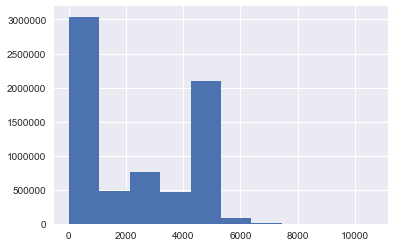

In [23]:
%matplotlib inline
raw['rmse'].hist(bins=10)

In [24]:
pd.qcut(raw['rmse'], 6);

## Thresholding on rmse of  300 meters.

In [25]:
filtered = raw[raw['rmse'] <= 300]

In [26]:
print filtered.shape
print raw.shape

(2650928, 12)
(6944466, 12)


## Deduping filtered, will represent networkidentifier with the centroid.

In [27]:
filtered_deduped = filtered.drop_duplicates('networkidentifier')

In [28]:
filtered_deduped = filtered_deduped.drop(['eventtime', 'accountid', 'latitude', 'longitude', 'networktype', 'distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse'], axis=1);

In [29]:
filtered_deduped.sort_values(['latitude_mean', 'longitude_mean'])

networkidentifier  latitude_mean  longitude_mean
6477228  ac5c430a0af254f76a9222b722ba0e8f      12.658395       77.782174
6535741  1de1a6e6fdd617b83902dc9a9bca6ae4      12.659421       77.444918
3808306  4e6859b5cda71396807956a0c063998b      12.661305       77.749318
4564376  002ec0005ab62eb2a10134088a9eb4e6      12.661611       77.674662
944176   232b3d2634b248752b2283b15152aa19      12.661611       77.674662
3572730  a5b47056539c532515fe49548c673911      12.661769       77.746124
4988122  f11cd03d14046fe0675b9f140ceb4df6      12.664642       77.754896
6568049  2b9d2fffcead4879d56130cf6dcad9dd      12.664651       77.752016
1090813  c768dfbb90fad9e3d050ce0c4f6a5da0      12.664675       77.754791
5291069  b7afa3554d91a0188eb6bb03c9575040      12.664681       77.749582
5168829  d8709220c7f551ea791dd19d36b8e200      12.664682       77.749581
6701568  693d28bc5d396a109ac755dd73a2e86a      12.664776       77.673920
5827616  53aa3064c2a5bbd8610f1f1a34b09142      12.664829       77.674320
4297120  d247dcb48ca2c0086e7726fa941d67a3      12.664968       77.765114
6657177  824723abe6189d6f33283cd56ec4cc14      12.665176       77.762873
3696965  8cb84c80f61f63d6f20ee00ed18b8a28      12.665230       77.674169
11379    9144324f25ccdb254ca38ca00714c330      12.665242       77.448863
4231858  0a8acaa057f53fb390241edf756c02ff      12.665274       77.673839
6567669  41950b666ba9f94fd6e2db285870b88c      12.665317       77.674122
1565951  6fd57b2e8513101d16a4ed742ca86d77      12.665523       77.509738
2702216  a10d3732e1c9f92f6b56fb0b0f5b9fa4      12.665556       77.748393
4009247  98a518e601c714e2c27f23a594020657      12.666053       77.763353
1962215  517faee33deb749adae2c2064ec07851      12.667451       77.450854
1557575  4339f3c3c05f3f32e34878267de6e9ee      12.669403       77.441960
1544110  38c4858a80498b924cfbabe75b952042      12.669540       77.765056
4609958  9f8bae9f320b0557602c57e768ca7723      12.669560       77.427003
4113928  c879c0c467d37b992ddf265ee32ac702      12.670434       77.449018
4376720  235c54f0779db9ebeb5833b85b65c88c      12.670633       77.329310
6466712  2b0d6e329eec8af60d2de364972e0be9      12.670749       77.762733
1136506  5d1e945447decf5a4e9aebeb4d779bbe      12.671667       77.762735
...                                   ...            ...             ...
6806742  d06d4e5b40ceaacc69454cf769114a34      13.229648       77.546543
5103716  9fa5091609cbc8dde761af8d15b39588      13.229663       77.704279
6893657  843bf3470cc53dc23fb3226900dc7c29      13.229702       77.703377
1039614  dbb038680b111cf3ffbc515637496d81      13.229787       77.547955
625279   223918b595043de9dd1892b9850488bd      13.229803       77.546669
2140338  b0af61f7c8d1877b39d59475b37bfe93      13.229868       77.548520
2520739  8ae62c310dcf5a8b5cb77dc9def9b396      13.229952       77.546402
1312160  68c30f54872080ec86902aa26652750a      13.230002       77.731953
5566635  ed788623f49c62a8a3e975858319ff27      13.230014       77.546755
5590213  c297d9056e3a906daad08086cfa9dc04      13.230103       77.637296
1709624  d4e1ff0dcf787ccfdd3879681c3ad31a      13.230538       77.541826
6147755  71ae7ab594b4c36a21648a7c1805fadc      13.230546       77.671308
3898710  ea6c326010867dec21c59fbcbeef877e      13.230826       77.548121
1113942  90ff8d7a0aa1e068499d14a8ada9d271      13.231618       77.728219
2986045  992763c3260eacff8cdc4c8bba147554      13.231699       77.698059
5516634  9eae2c2da8b3f0d17390f519bae77e74      13.231711       77.710663
5830206  7e83d41626fbe1159cf4b51fe8c28d21      13.231983       77.692367
6329096  bef2c2c6101027aca093a95783950af9      13.231993       77.673074
6474858  7a7a58dba27d527ca03a1cce9c62eb62      13.231999       77.694731
1644707  37772cf494207e27eaf1f1c31c22f25f      13.232020       77.709890
4514451  aba9397a1623f16bbd2985f6d3d707af      13.232522       77.705895
5667776  afa72cba6caa2df89671c991d9e05abf      13.232604       77.709705
3425084  3d0fc93f6b365d8ee09a3443c3a679f2      13.232838       77.696690
10003    

## Testing discrepancies in the formula for calucaitng distance.

1. Calucating distances using the s2sphere's get_distance(), which uses lat longs.
2. Converting lat long into 3d vector. And calculating distance using euclidean_distance. 

If both are within tolerable range, will use euclidean_distance directly, to create KD/Ball Tree

In [30]:
ltlg1 = s2sphere.LatLng.from_degrees(28.629894, 77.219493)
p1 = ltlg1.to_point()
ltlg2 = s2sphere.LatLng.from_degrees(28.557125, 77.060695)
p2 = ltlg2.to_point()
print ltlg1.get_distance(ltlg2).radians * earthRadius

17488.4551368


In [31]:
from sklearn.metrics.pairwise import euclidean_distances
X = [[p1[0], p1[1], p1[2]]]
print euclidean_distances(X, [[p2[0], p2[1], p2[2]]])[0][0]*earthRadius

17488.4496462


## Within cities it doesn't matter which distance representaion is used. 

All distances are in meters.

## Creating a bbox around my apartment complex.

In [32]:
apartment = box(12.956787, 77.646059, 12.960801, 77.642484)
print apartment

POLYGON ((12.960801 77.64605899999999, 12.960801 77.642484, 12.956787 77.642484, 12.956787 77.64605899999999, 12.960801 77.64605899999999))


In [33]:
apartment_bbox = list(apartment.exterior.coords)
print apartment_bbox

[(12.960801, 77.646059), (12.960801, 77.642484), (12.956787, 77.642484), (12.956787, 77.646059), (12.960801, 77.646059)]


In [34]:
apartment_bounds_map = folium.Map( location=[12.96077,77.645139], zoom_start=30 )
for coord in apartment_bbox:
    folium.Marker( location=[ coord[0], coord[1] ] , icon=folium.Icon(color='red',icon='info-sign')).add_to( apartment_bounds_map )

## Engulfes my apartment and parts of the apartment next to mine and some commercial area including shops, offices and a hotel

## Utility which converts dataframe to follium map

In [35]:
def datafame_to_follium(df, lat_col, lng_col):
    lat = list(df[lat_col])
    lng = list(df[lng_col])
    latlon = zip(lat, lng)
    map_ = folium.Map( location=[lat[0],lng[0]], zoom_start=30 )
    is_first = True
    for coord in latlon:
        if is_first:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='red',icon='info-sign') ).add_to(map_)
            is_first=False
        else:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='green',icon='ok-sign') ).add_to(map_)
    return map_

## Calculating side lengths and patch area.

In [36]:
upper_right = s2sphere.LatLng.from_degrees(apartment_bbox[0][0], apartment_bbox[0][1])
upper_left = s2sphere.LatLng.from_degrees(apartment_bbox[1][0], apartment_bbox[1][1])
urul = upper_right.get_distance(upper_left).radians * earthRadius

In [37]:
lower_left = s2sphere.LatLng.from_degrees(apartment_bbox[2][0], apartment_bbox[2][1])
lower_right = s2sphere.LatLng.from_degrees(apartment_bbox[3][0], apartment_bbox[3][1])
lower_right.get_distance(lower_left).radians * earthRadius;

In [38]:
lrur = lower_right.get_distance(upper_right).radians * earthRadius

In [39]:
lower_left.get_distance(upper_left).radians * earthRadius;

In [40]:
areaofpatch =  urul*lrur
print 'Area of patch = ' + str(areaofpatch) + ' meter^2'

Area of patch = 172908.276432 meter^2


## Filtering rows if the mean of lat lon lies with this bbox. 

In [41]:
filtered.head()

accountid              eventtime  \
2302570  ACCFF3A39E229084B3D986066B468DBB5B83  2016-12-18 10:36:18.0   
4334034      AC19THAY02Q9APWC6FCI4JE89MP5EW0N  2016-12-15 12:42:38.0   
320346   ACCFF3A39E229084B3D986066B468DBB5B83  2016-12-04 08:48:05.0   
2272544  ACCFF3A39E229084B3D986066B468DBB5B83  2016-12-18 09:54:37.0   
5740247  ACCFF3A39E229084B3D986066B468DBB5B83  2016-12-27 21:23:05.0   

          latitude  longitude                 networkidentifier networktype  \
2302570  12.929757  77.670166  569212f260c094dc7a5e943d2dce88b1        WiFi   
4334034  12.929757  77.670166  569212f260c094dc7a5e943d2dce88b1        WiFi   
320346   12.929757  77.670166  569212f260c094dc7a5e943d2dce88b1        WiFi   
2272544  12.929757  77.670166  569212f260c094dc7a5e943d2dce88b1        WiFi   
5740247  12.929757  77.670166  569212f260c094dc7a5e943d2dce88b1        WiFi   

         latitude_mean  longitude_mean  distance_from_centeroid  \
2302570      12.929091       77.669525               101.602583   
4334034      12.929091       77.669525               101.602583   
320346       12.929091       77.669525               101.602583   
2272544      12.929091       77.669525               101.602583   
5740247      12.929091       77.669525               101.602583   

         distance_from_centeroid_mean     absdiff        rmse  
2302570                    258.685075  157.082493  299.963139  
4334034                    258.685075  157.082493  299.963139  
320346                     258.685075  157.082493  299.963139  
2272544                    258.685075  157.082493  299.963139  
5740247                    258.685075  157.082493  299.963139

In [42]:
def within(x):
    p = point.Point(x[2], x[3])
    return p.within(apartment)
filtered['dd'] = filtered.apply(within, axis=1)

/Users/karan.verma/miniconda2/envs/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
df_dd = filtered.loc[filtered.dd == True]

In [44]:
df_dd.shape

(3007, 13)

In [45]:
df_dd.describe(include=['O'])

accountid              eventtime  \
count                               2955                   3007   
unique                               455                   2902   
top     ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U  2016-12-11 18:54:37.0   
freq                                 169                      3   

                       networkidentifier networktype  
count                               3007        3007  
unique                               347           5  
top     a5bd4301e6c358ee6f8f860ac2a9061d        WiFi  
freq                                 175        2889

# Plotting them on the map.

Plot includes only the mean of lat long for unique account ids within the bbox around my apartment.

In [46]:
lat = list(df_dd['latitude_mean'])
lng = list(df_dd['longitude_mean'])
latlon = zip(lat, lng)

In [47]:
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='green',icon='ok-sign') ).add_to( apartment_bounds_map )

# Analysing users in this patch

## Querying hive for data associated to list of accountids near my apartment.

In [48]:
accountids = list(set(list(df_dd['accountid'])))[1:]

In [49]:
accountids = ",".join(accountids)

In [50]:
def double_quote(word):
    double_q = '"' # double quote
    return double_q + word + double_q
accountids = double_quote(accountids)

In [51]:
query =  'SELECT data.accountid, data.firstname, data.lastname, data.active, data.phone, data.addressline1, data.addressline2, data.state, data.city,  data.pincode, data.lastmodified, data.addresscreation.creatingsystem, data.addresscreation.guest, data.addresscreation.creationdate FROM bigfoot_snapshot.dart_fkint_cp_user_address_6_0_view_total where  find_in_set(data.accountid, ' +accountids+ ')>0' 
def query_hive(query):
    cursor = hive.connect('prod-bheema-hive-2-1-0-0001',username='fk-bigfoot-read',configuration={'mapred.job.queue.name': 'adhoc'}).cursor()
    cursor.execute(query, async=True)

    status = cursor.poll().operationState
    while status in (TOperationState.INITIALIZED_STATE, TOperationState.RUNNING_STATE):
        logs = cursor.fetch_logs()
        for message in logs:
            print message
        status = cursor.poll().operationState
        
    data_hive = cursor.fetchall()
    return data_hive

## Converting hive query result to dataframe and saving to json file.

In [52]:
override = 0

In [53]:
hive_address_data_path= "../distances_samik_data/address_data.json"
if os.path.exists(hive_address_data_path) and os.path.getsize(hive_address_data_path) > 0:
    address_dataframe = pd.read_json(hive_address_data_path)
else:
    address_data_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')
if override:
    address_data_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')

In [54]:
address_dataframe.describe(include=['O'])

accountid  \
count                               2428   
unique                               334   
top     AC9URZUIW7S1GVI7DGX6GJ9L1HC53E19   
freq                                  34   

                                          addressline1 addressline2  \
count                                             2428         2371   
unique                                            1879          681   
top     No. 35, 1st floor, Main Kormangla road Adugodi                
freq                                                 9         1259   

             city creatingsystem           creationdate firstname  \
count        2428           2401                   2428      2428   
unique        237              1                   2289       940   
top     Bangalore            web  2012-06-29 02:48:36.0     Ayush   
freq         1183           2401                      7        30   

                 lastmodified lastname       phone      state  
count                    2428     2428        2428       2428  
unique                   2259      544         956         24  
top     2012-06-29 02:48:36.0           9845234001  Karnataka  
freq                        6      376          21       1433

### Joining address_dataframe with df_dd

In [55]:
df_dd.describe(include=['O'])

accountid              eventtime  \
count                               2955                   3007   
unique                               455                   2902   
top     ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U  2016-12-11 18:54:37.0   
freq                                 169                      3   

                       networkidentifier networktype  
count                               3007        3007  
unique                               347           5  
top     a5bd4301e6c358ee6f8f860ac2a9061d        WiFi  
freq                                 175        2889

In [56]:
df_dd_joined = pd.merge(df_dd, address_dataframe, on='accountid', sort=False)

In [57]:
df_dd_joined = df_dd_joined.drop(['distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse', 'dd',  u'creatingsystem', u'creationdate', u'guest'], axis=1)

In [58]:
df_dd_joined.describe(include=['O'])

accountid              eventtime  \
count                              17579                  17579   
unique                               334                   2068   
top     ACB1H0B4UW0O75Z6WJ9X6FLT8M5ZSU8U  2016-12-04 15:04:13.0   
freq                                3718                     54   

                       networkidentifier networktype  \
count                              17579       17579   
unique                               242           5   
top     a5bd4301e6c358ee6f8f860ac2a9061d        WiFi   
freq                                3826       17116   

                             addressline1 addressline2       city  firstname  \
count                               17579        17366      17579      17579   
unique                               1879          681        237        940   
top     D5/367C, Vikas Khand, Gomti Nagar               Bangalore  Abhilasha   
freq                                  676         9212       8782       1183   

                 lastmodified  lastname       phone      state  
count                   17579     17579       17579      17579  
unique                   2259       544         956         24  
top     2014-08-18 14:55:22.0  Upadhyay  9620274302  Karnataka  
freq                      338      2559        1183      11011

### Getting derived account data

In [59]:
override = 0

In [60]:
query =  'SELECT data FROM bigfoot_snapshot.dart_fkint_cp_uie_derived_account_3_0_view_total where  find_in_set(entityid, ' +accountids+ ')>0'
hive_derived_account_data_path= "../distances_samik_data/derived_account_data.json"
if os.path.exists(hive_derived_account_data_path) and os.path.getsize(hive_derived_account_data_path) > 0:
    derived_account_dataframe = pd.read_json(hive_derived_account_data_path)
else:
    derived_account_hive = query_hive(query)
    derived_account_hive = [json.loads(data[0]) for data in derived_account_hive]
    derived_account_dataframe = pd.DataFrame(derived_account_hive)
    derived_account_dataframe.to_json(hive_derived_account_data_path)
if override:
    derived_account_hive = query_hive(query)
    address_dataframe = pd.DataFrame(address_data_hive, columns=['accountid', 'firstname', 'lastname', 'active', 'phone', 'addressline1', 'addressline2', 'state', 'city',  'pincode', 'lastmodified', 'creatingsystem', 'guest', 'creationdate'])
    address_dataframe.to_json('../distances_samik_data/address_data.json')

In [61]:
derived_account_dataframe

account_id  app_visits  creation_date_ts  \
0        AC7XTZ67LRJZD6HHFQI7DYEMKO1RPVFN      4326.0               NaN   
1        ACORGR2S6FM3K8VQ1LBQNRFU99V1P8J9       117.0               NaN   
10                   ACC13930586411617987      1718.0               NaN   
100  ACC2B1EFC63870E4EBC8412E52E2D3D9C1CO       178.0               NaN   
101  ACC4C2B585641004850AE8D03F49621D67BL         NaN               NaN   
102      ACIL5NLUROWYAA25Z2SBJWU8BUVB7KIM        57.0               NaN   
103                  ACC13723988876817923      1259.0               NaN   
104      ACO7WEVT5RC9N89O62VYPY1HF4XCCZI0       420.0               NaN   
105      ACCHO7WFISOOZPMNFM7V677KQ46VEFVX      5193.0               NaN   
106                  ACC13799068510776437       117.0               NaN   
107                   ACC1385101244691859      3969.0               NaN   
108      ACJRXKTG3ORBZ346CQV10X7WCSDDBH8W      2690.0               NaN   
109                  ACC13566117787109364      2598.0               NaN   
11                    ACC1416161405086637      3249.0               NaN   
110  ACCD60FC04CAB244D3A8F764CD600495C131        90.0               NaN   
111                  ACC13993075987781221       441.0               NaN   
112      ACZM85LSMDUC39ZOFU99QFC23XJ4I8ZP       815.0               NaN   
113                  ACC14087136175642616       468.0               NaN   
114  ACC9DC934D339B549D38C62E0011EFD18B5H       696.0               NaN   
115  ACC9F1A76C43AD14117A3DE1167D8449035X      1347.0               NaN   
116                  ACC13999853262071807      2102.0               NaN   
117                  ACC14074333165188656      2231.0               NaN   
118                  ACC14100992095642143        21.0               NaN   
119  ACC476D4E47C60B40998C19EC87B919C57BQ       384.0               NaN   
12       ACQ16X2NV40VDSCXPIBX6UDQ044KOW71       311.0               NaN   
120                  ACC13677641507624404      1778.0               NaN   
121  ACCED1EE53C39FE44A49833617228844F18P         NaN               NaN   
122      AC1KLCG5LSTDQOUWKW42IVM4N2TW4U8H        93.0               NaN   
123      ACEQYFY07IDIMGU442GDVG3AK67K1H3A      1198.0               NaN   
124      ACBYSAG0BYIZECQDY3Q7Z45FN2USTVJQ      2984.0               NaN   
..                                    ...         ...               ...   
72       ACD5C1XEWRSYLNYIKWJVP54FAWPWN7CG       444.0               NaN   
73       ACDU7QWXGIK7LMYH7I1588FVGYTI9AJO       347.0               NaN   
74       AC8BZJLVP9U7HFWJPRBMF0347BQWN5M2      1346.0               NaN   
75   ACC860D87ADA06C427FA5934D836BB6C1A5V       635.0               NaN   
76   ACCD2EA4F26734845039DC0AFA2AC8F800AX       371.0               NaN   
77                   ACC14095031618074052      1219.0               NaN   
78                   ACC14268595510725394      3277.0               NaN   
79                   ACC13761520653364803       418.0               NaN   
8    ACC064A39F29B1B40588EFE15A4679D9FABI      1137.0               NaN   
80                   ACC13881991648048972       687.0               NaN   
81   ACC311D8A0D6BBA4614AEC1FFA2046CE2C5A       611.0               NaN   
82   ACC6432F39894054993B78C96CB225B5A856      1705.0               NaN   
83   ACCCADD19FBF446481FA9FED340A7D450CAM       535.0               NaN   
84                   ACC13804662810675203      1267.0               NaN   
85                   ACC13651494344661186      1960.0               NaN   
86                   ACC13677646225079258       322.0               NaN   
87       ACP45KDX10E6C0NMBCAU1JN5YG4EW18B      4317.0               NaN   
88                   ACC13484062779551064      2801.0               NaN   
89       ACZELUJAQCZJ1S2OIOTSVEQSCIRLJY60      1538.0               NaN   
9        ACLGQ73D9UBJ5DOXWKHBMOW1YZVS1DI3      6270.0               NaN   
90       AC2EEXBKZAU9OI03S59OGXNI8U0QWXXO       803.0               NaN   
91                   ACC13819985308485489      2268.0   

In [62]:
derived_account_dataframe.rename(columns={'account_id': 'accountid'}, inplace=True)

In [63]:
df_dd_joined_again = pd.merge(df_dd_joined, derived_account_dataframe, on='accountid', sort=False)

In [64]:
df_dd_joined_again.columns

Index([               u'accountid',                u'eventtime',
                       u'latitude',                u'longitude',
              u'networkidentifier',              u'networktype',
                  u'latitude_mean',           u'longitude_mean',
                         u'active',             u'addressline1',
                   u'addressline2',                     u'city',
                      u'firstname',             u'lastmodified',
                       u'lastname',                    u'phone',
                        u'pincode',                    u'state',
                     u'app_visits',         u'creation_date_ts',
                  u'customer_type',               u'first_name',
         u'first_purchase_date_ts',          u'gender_behavior',
                    u'gender_name',                u'is_active',
                 u'is_blacklisted',              u'is_customer',
                      u'is_parent',               u'is_student',
            u'last_browse

In [177]:
 pd.options.display.max_colwidth = 200

In [180]:
pd.options.display.max_rows = 600

In [181]:
df_dd_joined_again[[u'accountid', 'networkidentifier', 'gender_name', 'gender_behavior']]

accountid                 networkidentifier  \
0          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
1          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
2          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
3          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
4          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
5          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
6          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
7          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
8          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
9          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
10         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
11         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
12         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
13         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
14         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
15         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
16         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
17         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
18         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
19         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
20         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
21         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
22         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
23         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
24         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
25         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
26         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
27         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
28         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
29         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
30         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
31         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
32         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
33         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
34         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
35         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
36         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
37         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
38         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
39         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
40         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
41         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
42         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
43         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
44         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
45         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
46         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
47         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151f7270ad1b704   
48         ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  b3dbae4538ec5e8f3151

In [65]:
unique_accounts_counts = df_dd_joined_again.groupby('networkidentifier').accountid.nunique()
unique_accounts_counts = unique_accounts_counts.to_frame()

In [66]:
more_than_one = unique_accounts_counts.loc[unique_accounts_counts.accountid>1]

In [67]:
more_than_one_nids = list(more_than_one.index)

In [68]:
greater_than_1_nids_df = df_dd_joined_again.loc[df_dd_joined_again['networkidentifier'].isin(more_than_one_nids) ]

In [69]:
greater_than_1_nids_df_dedup = greater_than_1_nids_df.drop_duplicates('networkidentifier')

In [70]:
one_and_more_accids_deduped = df_dd_joined_again.drop_duplicates('networkidentifier')

In [71]:
dd_plot_for_nids_with_one_and_more_accids_deduped = datafame_to_follium(one_and_more_accids_deduped, 'latitude','longitude')

In [72]:
dd_plot_for_nids_with_one_and_more_accids_deduped

In [73]:
one_and_more_accids_deduped

accountid              eventtime   latitude  \
0          ACNU1Z337KIHCAUMMVNICNBOA2TE0Y63  2016-12-13 00:41:56.0  12.958746   
94                     ACC14036877573272097  2016-12-26 14:21:47.0  12.960148   
120                    ACC13810524313056592  2016-12-27 16:30:38.0  12.959795   
156    ACCCADD19FBF446481FA9FED340A7D450CAM  2016-12-18 15:57:18.0  12.960518   
159        ACU7SCD4TL4UXFUG7HLLIFB82NULXH2E  2016-12-18 19:43:12.0  12.958316   
173        ACEQYFY07IDIMGU442GDVG3AK67K1H3A  2017-01-03 22:47:57.0  12.960581   
175                    ACC14083465615604521  2016-12-27 14:47:07.0  12.959686   
367        ACZD03OQACCWS55YG93ZAO5IRXWIP2HN  2016-12-03 12:24:01.0  12.959860   
432        ACZD03OQACCWS55YG93ZAO5IRXWIP2HN  2016-12-28 23:19:29.0  12.958389   
462                    ACC13946897367268572  2016-12-12 20:38:34.0  12.960311   
476        ACMIQEJM8DMLEZY4BBUQAJ01F3NZKX5C  2016-12-30 00:00:54.0  12.960022   
484        ACZM85LSMDUC39ZOFU99QFC23XJ4I8ZP  2016-12-18 23:04:56.0  12.959265   
504                    ACC13455677180676661  2016-12-04 13:35:10.0  12.959126   
624                    ACC14015226901001861  2016-12-09 10:27:54.0  12.960236   
625        ACRGKSEX0DL440H5IH50LYLUDO4OLM0P  2017-01-04 02:07:50.0  12.960001   
645                     ACC1385101244691859  2016-12-04 02:28:23.0  12.960142   
681        ACTMA6E4Q1CQ672QD0LU5343DRGNDWYI  2016-12-17 16:56:13.0  12.959933   
745        ACTMA6E4Q1CQ672QD0LU5343DRGNDWYI  2016-12-18 02:11:19.0  12.959305   
777                    ACC13494514726645717  2017-01-03 20:56:37.0  12.959721   
785                    ACC13455881605585785  2016-12-23 20:58:50.0  12.960547   
788                      ACC136811232705531  2016-12-19 12:01:07.0  12.959676   
793    ACC26281F3611E9429FBA25BC69C73F95BDW  2016-12-20 11:16:41.0  12.960281   
812        ACZNL1I1JOBQRMJQ7WC2SU109757FAPX  2017-01-03 16:12:04.0  12.958149   
825        ACOPV78YI0OK6SYZL8ZESI0IX3KPEV6G  2016-12-20 15:35:52.0  12.957888   
849                    ACC13682775468369127  2016-12-18 03:25:53.0  12.959324   
1306                   ACC14117213206076305  2016-12-02 18:41:33.0  12.959264   
1412                   ACC13825482924444471  2016-12-25 16:09:12.0  12.959402   
1442       ACNWUEID8TO24M9Y2S5WWOU4RGT339QM  2016-12-19 15:24:22.0  12.960201   
1633                   ACC14263572675323125  2016-12-05 00:04:00.0  12.960117   
1909                   ACC13771866936055988  2017-01-03 14:01:37.0  12.960231   
...                                     ...                    ...        ...   
17145                  ACC13993075987781221  2016-12-10 09:52:48.0  12.958267   
17157                  ACC13628579646069951  2016-12-21 10:21:12.0  12.959176   
17161      ACKL3BCLKWALDTFJ1XWT5OOZG62P0NR6  2016-12-22 23:07:44.0  12.957714   
17173                  ACC13596099912358106  2016-12-26 12:58:56.0  12.959608   
17183      AC0K2K73AMJEDVJN9DL1ICTLRY7AGL4F  2016-12-13 21:27:43.0  12.958275   
17207      ACQC43YYH4PAJURSM52YNUGF11D96H4X  2016-12-18 09:25:02.0  12.958393   
17219                  ACC13455799809989577  2016-12-23 15:57:11.0  12.958235   
17264                  ACC13731861501833050  2016-12-28 15:39:22.0  12.959072   
17308      ACTWA5U93UEKZ7F6KKF7WVSTKNQHAVYX  2016-12-16 20:57:33.0  12.958196   
17340      ACTN9O1AETVEERO0J5SW3T2TMZ8U7LKE  2016-12-09 09:00:39.0  12.958691   
17345                  ACC14100157545921978  2016-12-14 02:30:14.0  12.957443   
17350      ACQF361X67LA2LHKII8OD92KDNQ7N0J5  2016-12-22 15:52:26.0  12.959248   
17386      AC2EEXBKZAU9OI03S59OGXNI8U0QWXXO  2016-12-11 08:47:21.0  12.959546   
17404      ACCHO7WFISOOZPMNFM7V677KQ46VEFVX  2016-12-17 11:14:44.0  12.960218   
17446      ACGVSSXL8CY7W3AR1LRIZU57YR6A14JH  2016-12-07 13:29:47.0  12.960046   
17486                  ACC13455595290236012  2016-12-11 15:33:55.0  12.959082   
17501                  ACC14157224121061117  2017-01-05 08:52:40.0  12.960288   
17502                  ACC14005884405368210  2016-12-23 22:06:48.

In [74]:
dd_plot_for_one_and_more_nids = datafame_to_follium(one_and_more_accids_deduped, 'latitude','longitude')

In [75]:
df_dd_joined_again['eventtime'] = pd.to_datetime(df_dd_joined_again['eventtime'])

In [76]:
df_dd_joined_again['dayofweek'] = df_dd_joined_again['eventtime'].apply(lambda x : x.dayofweek)

In [77]:
df_dd_joined_again['hour'] = df_dd_joined_again['eventtime'].apply(lambda x : x.hour)
df_dd_joined_again.loc[:, ['eventtime', 'dayofweek', 'hour']]

eventtime  dayofweek  hour
0     2016-12-13 00:41:56          1     0
1     2016-12-13 00:41:56          1     0
2     2016-12-13 00:41:56          1     0
3     2016-12-13 00:41:56          1     0
4     2016-12-13 00:41:56          1     0
5     2016-12-13 00:41:56          1     0
6     2016-12-13 00:41:56          1     0
7     2016-12-02 22:35:53          4    22
8     2016-12-02 22:35:53          4    22
9     2016-12-02 22:35:53          4    22
10    2016-12-02 22:35:53          4    22
11    2016-12-02 22:35:53          4    22
12    2016-12-02 22:35:53          4    22
13    2016-12-02 22:35:53          4    22
14    2016-12-11 13:48:45          6    13
15    2016-12-11 13:48:45          6    13
16    2016-12-11 13:48:45          6    13
17    2016-12-11 13:48:45          6    13
18    2016-12-11 13:48:45          6    13
19    2016-12-11 13:48:45          6    13
20    2016-12-11 13:48:45          6    13
21    2016-12-13 00:43:17          1     0
22    2016-12-13 00:43:17          1     0
23    2016-12-13 00:43:17          1     0
24    2016-12-13 00:43:17          1     0
25    2016-12-13 00:43:17          1     0
26    2016-12-13 00:43:17          1     0
27    2016-12-13 00:43:17          1     0
28    2016-12-13 22:09:08          1    22
29    2016-12-13 22:09:08          1    22
...                   ...        ...   ...
17549 2017-01-03 15:48:15          1    15
17550 2017-01-03 15:47:56          1    15
17551 2017-01-03 15:47:56          1    15
17552 2017-01-03 15:47:43          1    15
17553 2017-01-03 15:47:43          1    15
17554 2016-12-13 13:32:48          1    13
17555 2016-12-13 13:32:48          1    13
17556 2016-12-26 21:42:19          0    21
17557 2016-12-26 21:42:19          0    21
17558 2016-12-02 17:48:59          4    17
17559 2016-12-02 17:48:59          4    17
17560 2016-12-02 17:48:59          4    17
17561 2016-12-02 17:48:59          4    17
17562 2016-12-02 17:52:18          4    17
17563 2016-12-02 17:52:18          4    17
17564 2016-12-02 17:52:18          4    17
17565 2016-12-02 17:52:18          4    17
17566 2016-12-18 20:28:21          6    20
17567 2016-12-18 20:28:21          6    20
17568 2016-12-18 20:28:21          6    20
17569 2016-12-18 20:28:21          6    20
17570 2016-12-18 20:28:21          6    20
17571 2016-12-18 20:28:21          6    20
17572 2016-12-18 20:28:21          6    20
17573 2016-12-18 20:28:21          6    20
17574 2016-12-18 20:28:21          6    20
17575 2016-12-18 20:28:21          6    20
17576 2016-12-18 20:28:21          6    20
17577 2016-12-18 20:28:21          6    20
17578 2016-12-07 13:34:43          2    13

[17579 rows x 3 columns]

In [78]:
def hour_to_abstract_time(x):
    hour=x[0]
    dayofweek=x[1]
    if dayofweek in [0, 1, 2, 3, 4]:
        if hour >= 9 and hour <= 17:
            return 'office_hour'
        if hour >= 18 and hour <= 19 :
            return 'office_or_home'
        elif hour >= 6 and hour < 9:
            return 'early_morning_weekday'
        elif hour in [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]:
            return 'post_office_time'
    else:
        if hour >= 9 and hour <= 18:
            return 'weekend_day'
        elif hour >= 6 and hour < 9:
            return 'weekend_early_morning'
        elif hour in [19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]:
            return 'weekend_night'

In [79]:
df_dd_joined_again['abstract_time'] = df_dd_joined_again.loc[:,['hour', 'dayofweek']].apply(hour_to_abstract_time, axis=1)

## Deriving Connection counts based on time of the day

In [80]:
grouped_count = df_dd_joined_again[['abstract_time','networkidentifier', 'accountid']].groupby(['networkidentifier', 'abstract_time']).agg(['count'])

In [81]:
grouped_count.reset_index(inplace=True)

In [82]:
grouped_count['count'] = grouped_count['accountid']['count']

In [83]:
grouped_count = grouped_count.drop('accountid', axis=1)

/Users/karan.verma/miniconda2/envs/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  if __name__ == '__main__':


In [84]:
grouped_count.reset_index(inplace=True)

In [85]:
grouped_count = pd.DataFrame(grouped_count.to_records())

In [86]:
grouped_count = grouped_count.rename(index=str, columns={"('count', '')": 'count', "('abstract_time', '')": 'abstract_time', "('networkidentifier', '')": 'networkidentifier'})

In [87]:
grouped_count = grouped_count.drop("('index', '')", axis=1);

In [88]:
grouped_count = grouped_count.drop("index", axis=1)

In [89]:
grouped_count

networkidentifier          abstract_time  count
0    0060b3fd8ae134697a8bc7493f45aff2       post_office_time     12
1    00930f756aafc3bf4ad225e767b4db2f  early_morning_weekday     24
2    00930f756aafc3bf4ad225e767b4db2f            office_hour    120
3    00930f756aafc3bf4ad225e767b4db2f         office_or_home     27
4    00930f756aafc3bf4ad225e767b4db2f       post_office_time     21
5    00930f756aafc3bf4ad225e767b4db2f            weekend_day    441
6    00930f756aafc3bf4ad225e767b4db2f  weekend_early_morning     24
7    00930f756aafc3bf4ad225e767b4db2f          weekend_night     12
8    00afaf171a8a526f67bd97eaa6d737a3            office_hour     12
9    00c3244738ad6bac7480a9798d730a5d            office_hour      5
10   00c3244738ad6bac7480a9798d730a5d       post_office_time      5
11   00dfbb1e4bdc8a7fa7c1e1bb182bf0e0            office_hour      6
12   050fabba7fd72b166452008ab8cb36af            office_hour      2
13   05cd899afb852ce351b28b6cc5def7ed         office_or_home     39
14   071feb35f54c8679d43b6677b19cc337            office_hour      3
15   071feb35f54c8679d43b6677b19cc337       post_office_time     19
16   0730cb90130bd87ba6023e63a7ea3503       post_office_time     10
17   0799938cdecd0aa373e8f8a10a2b4e72  early_morning_weekday     90
18   0799938cdecd0aa373e8f8a10a2b4e72       post_office_time    420
19   081374e5521a35028de7e42a4c6c202a            office_hour     12
20   0922a26559c47e17c4d6166b5e493453            office_hour      6
21   0941b1b097fd3fd11a25ce8a76c71deb         office_or_home      1
22   0941b1b097fd3fd11a25ce8a76c71deb          weekend_night      2
23   094c91e1051eea7398423251be77aa22            office_hour     19
24   09c06b0fa475bce518466908f6595196            office_hour      4
25   09c06b0fa475bce518466908f6595196  weekend_early_morning      2
26   0b08e781198e44bcd8baa3584a2ab624       post_office_time      5
27   0b507471ea23cb42b3ad348f1b830c38            office_hour      3
28   0c64a0d4d06fc2236b8ac1400cccfdc2  early_morning_weekday     12
29   0c64a0d4d06fc2236b8ac1400cccfdc2            office_hour     18
..                                ...                    ...    ...
394  e8a31bd49893cdf8107a000c1dc5c9c2       post_office_time      4
395  ebb5507d255cf74d266fc331ef745019       post_office_time     18
396  ecc27d841de07a80d48580d7262876d5            office_hour     21
397  ed7120e581ba96db465acaac4e3b0b53            office_hour     70
398  edd0fe4174fe18d00cec95b05d9a324f          weekend_night      6
399  ee1f66e710b33248e4179975efa149ee          weekend_night      4
400  ef347bcccd3da2d505cd877d058efcac            office_hour     15
401  ef347bcccd3da2d505cd877d058efcac       post_office_time      8
402  ef347bcccd3da2d505cd877d058efcac            weekend_day      8
403  f105d7568c7e5382d7d27dca38600ef1       post_office_time      5
404  f24233d00c12d30970ce3206c1eb1182         office_or_home     14
405  f24233d00c12d30970ce3206c1eb1182       post_office_time     21
406  f24233d00c12d30970ce3206c1eb1182            weekend_day     14
407  f24233d00c12d30970ce3206c1eb1182          weekend_night     14
408  f2c2949737603755a30d1670f366ae9b         office_or_home     13
409  f47d5fe45d6fb66d636718cb340e26fb            office_hour     19
410  f55a562e128acb02be706532d206cb8d            office_hour     10
411  f55a562e128acb02be706532d206cb8d       post_office_time     10
412  f5b2667b168ad011162627f830e87080            office_hour      2
413  f5ef28cf868e19ee321ba140c4940158       post_office_time     12
414  f64c3847a183597863367c43b88eaaca            office_hour     21
415  f66fc6a2d20f21a6caca131eb2a4a488            office_hour      2
416  f7aeabb9dad6e07b17d0de596854adc3            office_hour      7
417  f7aeabb9dad6e07b17d0de596854adc3            weekend_day      7
418  fae042067682910861e0488f2008f5dc          weekend_night      2
419  fafe5c5428f297933bf73878208d6d5c            weekend_day      7
420  fe0ebed5172795941fa8a2e162bd584d            office_hour     19
421  ff0

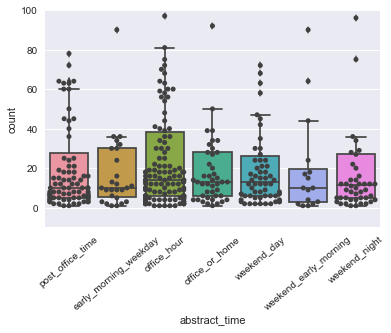

In [90]:
import matplotlib.pyplot as plt
plt.ylim(-10, 100)
plt.xticks(rotation=40)

ax = sns.boxplot(x="abstract_time", y="count", data=grouped_count)
ax = sns.swarmplot(x="abstract_time", y="count", data=grouped_count, color=".25")

In [91]:
df_dd_joined_again_with_grouped_count = pd.merge(df_dd_joined_again, grouped_count, on=['networkidentifier', 'abstract_time'], sort=False, suffixes='_j')

# Plot for Office Hours

In [92]:
df_dd_joined_again_with_grouped_count_for_follium = df_dd_joined_again_with_grouped_count.drop_duplicates(['networkidentifier', 'abstract_time'])

In [93]:
df_dd_joined_again_with_grouped_count_for_follium = df_dd_joined_again_with_grouped_count_for_follium.loc[:, ['accountid', 'networkidentifier', 'latitude_mean', 'longitude_mean', 'longitude', 'latitude', 'abstract_time', 'count']]

latitude_mean  longitude_mean   longitude    latitude       count
count     138.000000      138.000000  138.000000  138.000000  138.000000
mean       12.959420       77.644098   77.644018   12.959380   45.231884
std         0.001408        0.001905    0.000998    0.000945  102.658906
min        12.953182       77.634733   77.642560   12.956833    1.000000
25%        12.958696       77.643250   77.643209   12.958696    6.000000
50%        12.959661       77.643656   77.643702   12.959635   14.000000
75%        12.960149       77.645161   77.645048   12.960142   38.250000
max        12.966532       77.651902   77.646051   12.960762  748.000000

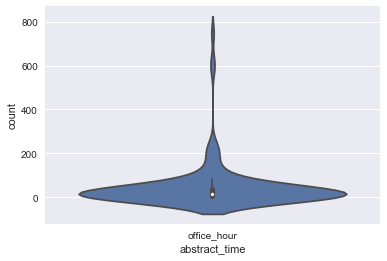

In [94]:
ax = sns.violinplot(x="abstract_time", y="count", data=df_dd_joined_again_with_grouped_count_for_follium[(df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='office_hour') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)])
df_dd_joined_again_with_grouped_count_for_follium[(df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='office_hour') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)].describe()

## Network Identifiers in offices during office hours

In [95]:
office_hour_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='office_hour') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 15)   

In [96]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[office_hour_filter], 'latitude','longitude')

## Plot includes homes with count threshold less than 20 during office hours 

In [97]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[(df_dd_joined_again_with_grouped_count.abstract_time=='office_hour') & (df_dd_joined_again_with_grouped_count_for_follium["count"] < 15)], 'latitude','longitude')

# Network Identifiers post office hours.

latitude_mean  longitude_mean  longitude   latitude        count
count      88.000000       88.000000  88.000000  88.000000    88.000000
mean       12.958864       77.644160  77.644040  12.959167    45.590909
std         0.003658        0.005309   0.001001   0.000968   135.086829
min        12.930306       77.609698  77.642560  12.956833     1.000000
25%        12.958268       77.643094  77.643187  12.958411     5.000000
50%        12.959009       77.643888  77.643840  12.959034    10.000000
75%        12.960106       77.644994  77.644809  12.960054    27.750000
max        12.971233       77.673717  77.646051  12.960661  1154.000000

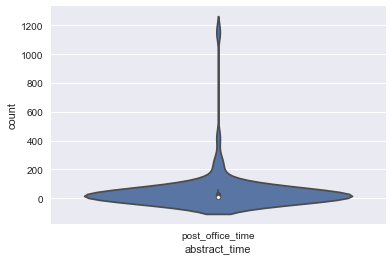

In [98]:
ax = sns.violinplot(x="abstract_time", y="count", data=df_dd_joined_again_with_grouped_count_for_follium[(df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='post_office_time') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)])
df_dd_joined_again_with_grouped_count_for_follium[(df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='post_office_time') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)].describe()

In [99]:
post_office_hour_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='post_office_time') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 10)   

In [100]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[post_office_hour_filter], 'latitude','longitude')

### Post office hours on opposite threshold thresholds

In [101]:
post_office_hour_filter_opposite = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='post_office_time') & (df_dd_joined_again_with_grouped_count_for_follium["count"] < 10)   

In [102]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[post_office_hour_filter_opposite], 'latitude','longitude')

## Plotting weekday early morning

In [103]:
weekday_early_morning_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='early_morning_weekday') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)   

In [104]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[weekday_early_morning_filter], 'latitude','longitude')

## Plotting weekend early morning

In [105]:
weekend_early_morning_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='weekend_early_morning') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1)   


In [106]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[weekend_early_morning_filter], 'latitude','longitude')

## Plotting weekend day

In [107]:
weekend_day_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='weekend_day') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1) 

In [108]:
df_dd_joined_again_with_grouped_count_for_follium.loc[weekend_day_filter].describe()

latitude_mean  longitude_mean  longitude   latitude       count
count      62.000000       62.000000  62.000000  62.000000   62.000000
mean       12.958539       77.643836  77.643991  12.958878   40.500000
std         0.002326        0.001557   0.000976   0.000916   99.454702
min        12.943011       77.634733  77.642650  12.956828    2.000000
25%        12.958210       77.643118  77.643187  12.958254    6.000000
50%        12.958804       77.643634  77.643679  12.958799   13.000000
75%        12.959695       77.644957  77.644942  12.959796   26.250000
max        12.961030       77.646122  77.645989  12.960518  638.000000

In [109]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[weekend_day_filter], 'latitude','longitude')

## Weekend night

In [110]:
weekend_night_filter = (df_dd_joined_again_with_grouped_count_for_follium.abstract_time=='weekend_night') & (df_dd_joined_again_with_grouped_count_for_follium["count"] >= 1) 

In [111]:
df_dd_joined_again_with_grouped_count_for_follium.loc[weekend_night_filter].describe()

latitude_mean  longitude_mean  longitude   latitude       count
count      48.000000       48.000000  48.000000  48.000000   48.000000
mean       12.959057       77.644124  77.644251  12.958918   41.270833
std         0.001794        0.002224   0.001169   0.000965   80.273930
min        12.953182       77.634733  77.642605  12.956833    1.000000
25%        12.958251       77.643017  77.643175  12.958246    5.000000
50%        12.958809       77.644180  77.644171  12.958767   11.500000
75%        12.959755       77.645312  77.645335  12.959770   27.250000
max        12.966793       77.650611  77.646051  12.960661  355.000000

In [112]:
datafame_to_follium(df_dd_joined_again_with_grouped_count_for_follium.loc[weekend_night_filter], 'latitude_mean','longitude_mean')

In [113]:
df_dd['just_date'] = pd.to_datetime(df_dd['eventtime']).dt.date

/Users/karan.verma/miniconda2/envs/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [114]:
dataframe_date_count = pd.DataFrame(df_dd.groupby(['networkidentifier', 'just_date'], as_index=False).size())

In [115]:
dataframe_date_count

0
networkidentifier                just_date     
0060b3fd8ae134697a8bc7493f45aff2 2016-12-02   1
00930f756aafc3bf4ad225e767b4db2f 2016-12-06   1
                                 2016-12-08  19
                                 2016-12-09   2
                                 2016-12-10  23
                                 2016-12-11  77
                                 2016-12-12  19
                                 2016-12-13   4
                                 2016-12-15   4
                                 2016-12-16   1
                                 2016-12-18   1
                                 2016-12-19   1
                                 2016-12-31   1
                                 2017-01-04   1
00afaf171a8a526f67bd97eaa6d737a3 2016-12-02   1
00c3244738ad6bac7480a9798d730a5d 2016-12-28   1
                                 2016-12-30   1
00dfbb1e4bdc8a7fa7c1e1bb182bf0e0 2016-12-21   1
                                 2016-12-27   1
050b685b8b34b91a1b6d158c5103dc6a 2016-12-01   2
                                 2016-12-03   1
050fabba7fd72b166452008ab8cb36af 2016-12-02   1
05cd899afb852ce351b28b6cc5def7ed 2016-12-14   1
                                 2016-12-22   1
                                 2017-01-04   1
0631bfa107489e3c8ab6b451606f48bf 2016-12-21   1
071feb35f54c8679d43b6677b19cc337 2016-12-01   1
                                 2016-12-29   1
0730cb90130bd87ba6023e63a7ea3503 2016-12-19   1
                                 2016-12-22   1
...                                          ..
fdb4dd6226c3f949e22d678dea88b1cc 2016-12-12   2
                                 2016-12-15   1
                                 2016-12-16   5
                                 2016-12-18  16
                                 2016-12-19  11
                                 2016-12-20   5
                                 2016-12-21   2
                                 2016-12-24   2
                                 2016-12-25   1
                                 2016-12-26   6
                                 2016-12-29   4
                                 2016-12-30   3
                                 2017-01-02   1
                                 2017-01-03   3
fe0ebed5172795941fa8a2e162bd584d 2016-12-01   1
ff0dac1f7ccd1962794099b501db3147 2016-12-10   3
                                 2016-12-12   2
                                 2016-12-14   2
                                 2016-12-16   4
                                 2016-12-19   1
                                 2016-12-20   4
                                 2016-12-21   4
                                 2016-12-22   1
                                 2016-12-26   1
                                 2016-12-28   4
                                 2016-12-29   1
                                 2017-01-02   2
                                 2017-01-03   2
ff1d514e23df13ffd1da6c0dd62356d9 2016-12-17   6
                                 2016-12-18  32

[1036 rows x 1 columns]

In [116]:
dataframe_date_count.reset_index(inplace=True, col_fill='t')

In [117]:
dataframe_date_count.sort_values(by=0)

networkidentifier   just_date   0
0     0060b3fd8ae134697a8bc7493f45aff2  2016-12-02   1
549   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-13   1
551   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-17   1
552   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-19   1
553   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-20   1
970   f24233d00c12d30970ce3206c1eb1182  2016-12-04   1
555   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-28   1
556   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-31   1
557   854d4df60c73d9d43d93a911e6bcc6d5  2017-01-03   1
558   85fe041143836f1647673c62f20281da  2016-12-05   1
559   85fe041143836f1647673c62f20281da  2016-12-19   1
561   85fe041143836f1647673c62f20281da  2016-12-30   1
562   85fe041143836f1647673c62f20281da  2017-01-02   1
563   85fe041143836f1647673c62f20281da  2017-01-03   1
564   86de502ad3fe05ceedaba87164d54d28  2016-12-13   1
565   86f865cf57d01cc77823d4a350b2d32a  2016-12-23   1
567   86f865cf57d01cc77823d4a350b2d32a  2016-12-25   1
569   86f865cf57d01cc77823d4a350b2d32a  2016-12-27   1
971   f24233d00c12d30970ce3206c1eb1182  2016-12-05   1
546   832226adae370ce51511e63cff68f138  2017-01-03   1
545   830cbb9692b632bd353e63c66e031204  2017-01-02   1
544   830cbb9692b632bd353e63c66e031204  2016-12-23   1
513   7f8fd88d37b88a6567bcf0e3fd164823  2016-12-21   1
514   7f8fd88d37b88a6567bcf0e3fd164823  2016-12-26   1
515   7fa5fbf40d33fe6b4a2ab91799e0ec04  2016-12-25   1
975   f24233d00c12d30970ce3206c1eb1182  2016-12-20   1
518   82461993a58a3e0402918e20e3858c11  2016-12-06   1
974   f24233d00c12d30970ce3206c1eb1182  2016-12-16   1
520   82461993a58a3e0402918e20e3858c11  2016-12-08   1
522   82461993a58a3e0402918e20e3858c11  2016-12-16   1
...                                ...         ...  ..
960   ee7454f41abdd0236328d7dbcdb5c515  2016-12-11  14
33    0799938cdecd0aa373e8f8a10a2b4e72  2016-12-08  14
219   28d2665b2d95b375419a6e1e6c629a33  2016-12-17  14
106   14ae6c62c0aa08a0206775c05cfd382c  2016-12-16  14
780   be4cfa04b2857aaed7ed483d90daba97  2016-12-01  15
160   1e5cdcb048da59a4b441d1db60328e23  2016-12-02  16
1009  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-18  16
669   a5bd4301e6c358ee6f8f860ac2a9061d  2016-12-18  16
688   abee19ed5c415283ce0ebb9cd5c96575  2016-12-17  16
166   2008d0ad239d742c5f18562b1d7769ea  2016-12-01  17
176   214211c164a598064505338c84f45b3b  2016-12-17  17
90    148b62608743d201412e2a10e308db47  2017-01-02  17
174   214211c164a598064505338c84f45b3b  2016-12-14  18
2     00930f756aafc3bf4ad225e767b4db2f  2016-12-08  19
149   1e2a1ef785a973d36ad01e91dfd2c654  2016-12-19  19
548   854d4df60c73d9d43d93a911e6bcc6d5  2016-12-12  19
6     00930f756aafc3bf4ad225e767b4db2f  2016-12-12  19
151   1e2a1ef785a973d36ad01e91dfd2c654  2016-12-21  20
908   e257633ccc89520a7c3ed2abf88ed44b  2016-12-07  20
159   1e5cdcb048da59a4b441d1db60328e23  2016-12-01  21
4     00930f756aafc3bf4ad225e767b4db2f  2016-12-10  23
345   4fd05800ec5a29a1753467dc9bf7e47e  2016-12-15  26
1035  ff1d514e23df13ffd1da6c0dd62356d9  2016-12-18  32
177   214211c164a598064505338c84f45b3b  2016-12-18  34
689   abee19ed5c415283ce0ebb9cd5c96575  2016-12-18  35
74    1382a9fd9451c83836e6140a9a1c6185  2016-12-18  36
666   a5bd4301e6c358ee6f8f860ac2a9061d  2016-12-15  38
665   a5bd4301e6c358ee6f8f860ac2a9061d  2016-12-14  49
346   4fd05800ec5a29a1753467dc9bf7e47e  2016-12-16  62
5     00930f756aafc3bf4ad225e767b4db2f  2016-12-11  77

[1036 rows x 3 columns]

In [118]:
dataframe_date_count = dataframe_date_count.rename({0:'actual_count'})

In [119]:
dataframe_date_count =dataframe_date_count.rename({0:'ac_count'})

In [120]:
dataframe_date_count

networkidentifier   just_date   0
actual_count  0060b3fd8ae134697a8bc7493f45aff2  2016-12-02   1
1             00930f756aafc3bf4ad225e767b4db2f  2016-12-06   1
2             00930f756aafc3bf4ad225e767b4db2f  2016-12-08  19
3             00930f756aafc3bf4ad225e767b4db2f  2016-12-09   2
4             00930f756aafc3bf4ad225e767b4db2f  2016-12-10  23
5             00930f756aafc3bf4ad225e767b4db2f  2016-12-11  77
6             00930f756aafc3bf4ad225e767b4db2f  2016-12-12  19
7             00930f756aafc3bf4ad225e767b4db2f  2016-12-13   4
8             00930f756aafc3bf4ad225e767b4db2f  2016-12-15   4
9             00930f756aafc3bf4ad225e767b4db2f  2016-12-16   1
10            00930f756aafc3bf4ad225e767b4db2f  2016-12-18   1
11            00930f756aafc3bf4ad225e767b4db2f  2016-12-19   1
12            00930f756aafc3bf4ad225e767b4db2f  2016-12-31   1
13            00930f756aafc3bf4ad225e767b4db2f  2017-01-04   1
14            00afaf171a8a526f67bd97eaa6d737a3  2016-12-02   1
15            00c3244738ad6bac7480a9798d730a5d  2016-12-28   1
16            00c3244738ad6bac7480a9798d730a5d  2016-12-30   1
17            00dfbb1e4bdc8a7fa7c1e1bb182bf0e0  2016-12-21   1
18            00dfbb1e4bdc8a7fa7c1e1bb182bf0e0  2016-12-27   1
19            050b685b8b34b91a1b6d158c5103dc6a  2016-12-01   2
20            050b685b8b34b91a1b6d158c5103dc6a  2016-12-03   1
21            050fabba7fd72b166452008ab8cb36af  2016-12-02   1
22            05cd899afb852ce351b28b6cc5def7ed  2016-12-14   1
23            05cd899afb852ce351b28b6cc5def7ed  2016-12-22   1
24            05cd899afb852ce351b28b6cc5def7ed  2017-01-04   1
25            0631bfa107489e3c8ab6b451606f48bf  2016-12-21   1
26            071feb35f54c8679d43b6677b19cc337  2016-12-01   1
27            071feb35f54c8679d43b6677b19cc337  2016-12-29   1
28            0730cb90130bd87ba6023e63a7ea3503  2016-12-19   1
29            0730cb90130bd87ba6023e63a7ea3503  2016-12-22   1
...                                        ...         ...  ..
1006          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-12   2
1007          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-15   1
1008          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-16   5
1009          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-18  16
1010          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-19  11
1011          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-20   5
1012          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-21   2
1013          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-24   2
1014          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-25   1
1015          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-26   6
1016          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-29   4
1017          fdb4dd6226c3f949e22d678dea88b1cc  2016-12-30   3
1018          fdb4dd6226c3f949e22d678dea88b1cc  2017-01-02   1
1019          fdb4dd6226c3f949e22d678dea88b1cc  2017-01-03   3
1020          fe0ebed5172795941fa8a2e162bd584d  2016-12-01   1
1021          ff0dac1f7ccd1962794099b501db3147  2016-12-10   3
1022          ff0dac1f7ccd1962794099b501db3147  2016-12-12   2
1023          ff0dac1f7ccd1962794099b501db3147  2016-12-14   2
1024          ff0dac1f7ccd1962794099b501db3147  2016-12-16   4
1025          ff0dac1f7ccd1962794099b501db3147  2016-12-19   1
1026          ff0dac1f7ccd1962794099b501db3147  2016-12-20   4
1027          ff0dac1f7ccd1962794099b501db3147  2016-12-21   4
1028          ff0dac1f7ccd1962794099b501db3147  2016-12-22   1
1029          ff0dac1f7ccd1962794099b501db3147  2016-12-26   1
1030          ff0dac1f7ccd1962794099b501db3147  2016-12-28   4
1031          ff0dac1f7ccd1962794099b501db3147  2016-12-29   1
1032          ff0dac1f7ccd1962794099b501db3147  2017-01-02   2
1033          ff0dac1f7ccd1962794099b501db3147  2017-01-03   2
1034          ff1d514e23df13ffd1da6c0dd62356d9  2016-12-17   6
1035          ff1d514e23df13ffd1da6c0dd62356d9  2016-12-18  32

[1036 rows x 3 columns]

In [121]:
dataframe_date_count[dataframe_date_count[0] > 1]

networkidentifier   just_date   0
2     00930f756aafc3bf4ad225e767b4db2f  2016-12-08  19
3     00930f756aafc3bf4ad225e767b4db2f  2016-12-09   2
4     00930f756aafc3bf4ad225e767b4db2f  2016-12-10  23
5     00930f756aafc3bf4ad225e767b4db2f  2016-12-11  77
6     00930f756aafc3bf4ad225e767b4db2f  2016-12-12  19
7     00930f756aafc3bf4ad225e767b4db2f  2016-12-13   4
8     00930f756aafc3bf4ad225e767b4db2f  2016-12-15   4
19    050b685b8b34b91a1b6d158c5103dc6a  2016-12-01   2
33    0799938cdecd0aa373e8f8a10a2b4e72  2016-12-08  14
34    0799938cdecd0aa373e8f8a10a2b4e72  2016-12-09   3
35    081374e5521a35028de7e42a4c6c202a  2016-12-14   3
54    0c64a0d4d06fc2236b8ac1400cccfdc2  2016-12-21   2
55    0c64a0d4d06fc2236b8ac1400cccfdc2  2016-12-22   2
59    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-24   2
61    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-26   3
63    0f70254e55c5ac160b83f101b5b16424  2016-12-27   3
68    12e05e72bf34893fe77465051b9f75c3  2016-12-07   2
70    12e05e72bf34893fe77465051b9f75c3  2016-12-16   2
73    1382a9fd9451c83836e6140a9a1c6185  2016-12-17   2
74    1382a9fd9451c83836e6140a9a1c6185  2016-12-18  36
77    148b62608743d201412e2a10e308db47  2016-12-06   2
80    148b62608743d201412e2a10e308db47  2016-12-15  13
81    148b62608743d201412e2a10e308db47  2016-12-16   2
82    148b62608743d201412e2a10e308db47  2016-12-18   2
83    148b62608743d201412e2a10e308db47  2016-12-19   2
85    148b62608743d201412e2a10e308db47  2016-12-21   2
89    148b62608743d201412e2a10e308db47  2016-12-29   3
90    148b62608743d201412e2a10e308db47  2017-01-02  17
92    148b62608743d201412e2a10e308db47  2017-01-05   3
93    14ae6c62c0aa08a0206775c05cfd382c  2016-12-01   2
...                                ...         ...  ..
986   f64c3847a183597863367c43b88eaaca  2016-12-22   2
987   f64c3847a183597863367c43b88eaaca  2016-12-26  12
989   f64c3847a183597863367c43b88eaaca  2016-12-28   4
990   f64c3847a183597863367c43b88eaaca  2016-12-29   2
996   f99e43170bf27eb3e35f1bd4958c247f  2016-12-11   2
997   f99e43170bf27eb3e35f1bd4958c247f  2016-12-12   3
1001  fac38e92116814d988041d9769096019  2017-01-02   3
1004  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-03   2
1006  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-12   2
1008  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-16   5
1009  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-18  16
1010  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-19  11
1011  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-20   5
1012  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-21   2
1013  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-24   2
1015  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-26   6
1016  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-29   4
1017  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-30   3
1019  fdb4dd6226c3f949e22d678dea88b1cc  2017-01-03   3
1021  ff0dac1f7ccd1962794099b501db3147  2016-12-10   3
1022  ff0dac1f7ccd1962794099b501db3147  2016-12-12   2
1023  ff0dac1f7ccd1962794099b501db3147  2016-12-14   2
1024  ff0dac1f7ccd1962794099b501db3147  2016-12-16   4
1026  ff0dac1f7ccd1962794099b501db3147  2016-12-20   4
1027  ff0dac1f7ccd1962794099b501db3147  2016-12-21   4
1030  ff0dac1f7ccd1962794099b501db3147  2016-12-28   4
1032  ff0dac1f7ccd1962794099b501db3147  2017-01-02   2
1033  ff0dac1f7ccd1962794099b501db3147  2017-01-03   2
1034  ff1d514e23df13ffd1da6c0dd62356d9  2016-12-17   6
1035  ff1d514e23df13ffd1da6c0dd62356d9  2016-12-18  32

[489 rows x 3 columns]

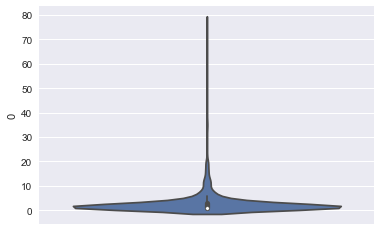

In [122]:
ax = sns.violinplot(y=0, data=dataframe_date_count)

In [123]:
dataframe_date_count.columns

Index([u'networkidentifier', u'just_date', 0], dtype='object')

In [124]:
nids = list(set(list(dataframe_date_count['networkidentifier'])))

In [125]:
filter_this = []
for i, nid in enumerate(nids):
    if dataframe_date_count[dataframe_date_count.networkidentifier==nid].groupby(['networkidentifier']).just_date.nunique()[0] >= 5:
        filter_this.append(nid)

In [140]:
more_than_5 = dataframe_date_count.loc[dataframe_date_count.networkidentifier.isin(filter_this)]
more_than_5

networkidentifier   just_date   0
1     00930f756aafc3bf4ad225e767b4db2f  2016-12-06   1
2     00930f756aafc3bf4ad225e767b4db2f  2016-12-08  19
3     00930f756aafc3bf4ad225e767b4db2f  2016-12-09   2
4     00930f756aafc3bf4ad225e767b4db2f  2016-12-10  23
5     00930f756aafc3bf4ad225e767b4db2f  2016-12-11  77
6     00930f756aafc3bf4ad225e767b4db2f  2016-12-12  19
7     00930f756aafc3bf4ad225e767b4db2f  2016-12-13   4
8     00930f756aafc3bf4ad225e767b4db2f  2016-12-15   4
9     00930f756aafc3bf4ad225e767b4db2f  2016-12-16   1
10    00930f756aafc3bf4ad225e767b4db2f  2016-12-18   1
11    00930f756aafc3bf4ad225e767b4db2f  2016-12-19   1
12    00930f756aafc3bf4ad225e767b4db2f  2016-12-31   1
13    00930f756aafc3bf4ad225e767b4db2f  2017-01-04   1
28    0730cb90130bd87ba6023e63a7ea3503  2016-12-19   1
29    0730cb90130bd87ba6023e63a7ea3503  2016-12-22   1
30    0730cb90130bd87ba6023e63a7ea3503  2016-12-23   1
31    0730cb90130bd87ba6023e63a7ea3503  2016-12-26   1
32    0730cb90130bd87ba6023e63a7ea3503  2016-12-29   1
56    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-18   1
57    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-20   1
58    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-21   1
59    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-24   2
60    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-25   1
61    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-26   3
62    0e9b734aa25ca8096cb7b56dc0dd8929  2016-12-27   1
76    148b62608743d201412e2a10e308db47  2016-12-01   1
77    148b62608743d201412e2a10e308db47  2016-12-06   2
78    148b62608743d201412e2a10e308db47  2016-12-07   1
79    148b62608743d201412e2a10e308db47  2016-12-13   1
80    148b62608743d201412e2a10e308db47  2016-12-15  13
...                                ...         ...  ..
990   f64c3847a183597863367c43b88eaaca  2016-12-29   2
1004  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-03   2
1005  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-09   1
1006  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-12   2
1007  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-15   1
1008  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-16   5
1009  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-18  16
1010  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-19  11
1011  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-20   5
1012  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-21   2
1013  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-24   2
1014  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-25   1
1015  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-26   6
1016  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-29   4
1017  fdb4dd6226c3f949e22d678dea88b1cc  2016-12-30   3
1018  fdb4dd6226c3f949e22d678dea88b1cc  2017-01-02   1
1019  fdb4dd6226c3f949e22d678dea88b1cc  2017-01-03   3
1021  ff0dac1f7ccd1962794099b501db3147  2016-12-10   3
1022  ff0dac1f7ccd1962794099b501db3147  2016-12-12   2
1023  ff0dac1f7ccd1962794099b501db3147  2016-12-14   2
1024  ff0dac1f7ccd1962794099b501db3147  2016-12-16   4
1025  ff0dac1f7ccd1962794099b501db3147  2016-12-19   1
1026  ff0dac1f7ccd1962794099b501db3147  2016-12-20   4
1027  ff0dac1f7ccd1962794099b501db3147  2016-12-21   4
1028  ff0dac1f7ccd1962794099b501db3147  2016-12-22   1
1029  ff0dac1f7ccd1962794099b501db3147  2016-12-26   1
1030  ff0dac1f7ccd1962794099b501db3147  2016-12-28   4
1031  ff0dac1f7ccd1962794099b501db3147  2016-12-29   1
1032  ff0dac1f7ccd1962794099b501db3147  2017-01-02   2
1033  ff0dac1f7ccd1962794099b501db3147  2017-01-03   2

[546 rows x 3 columns]

/Users/karan.verma/miniconda2/envs/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


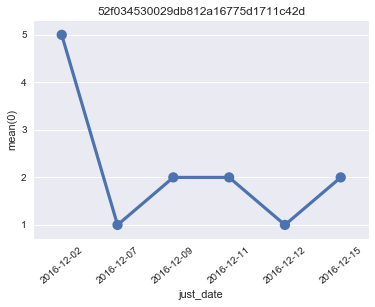

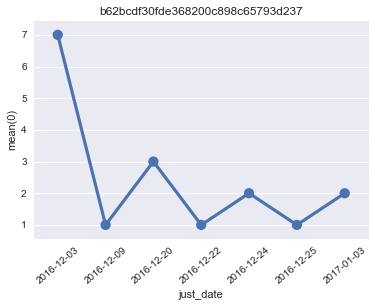

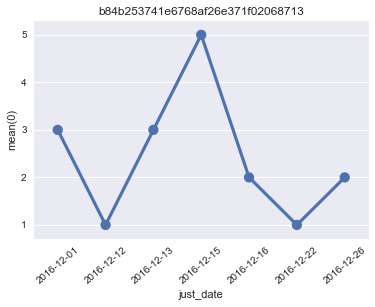

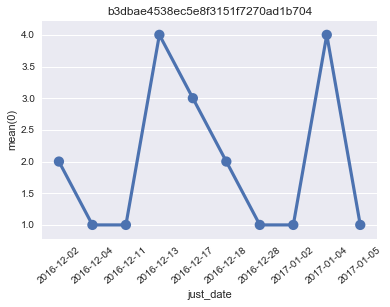

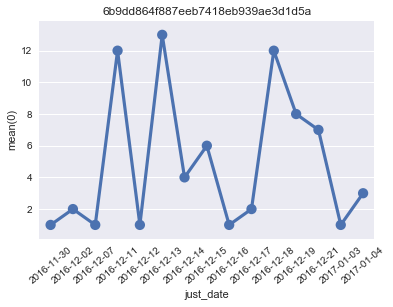

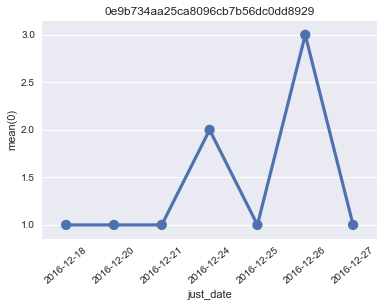

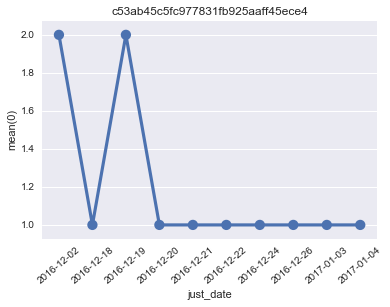

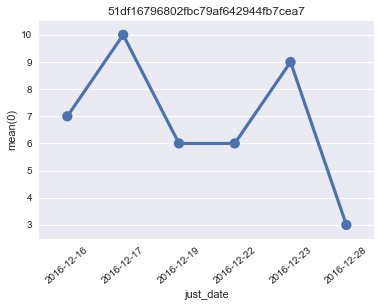

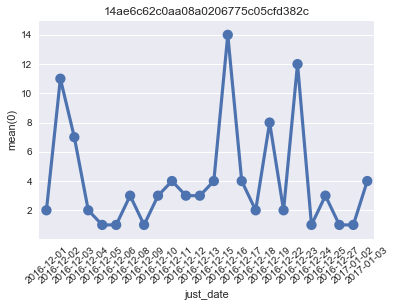

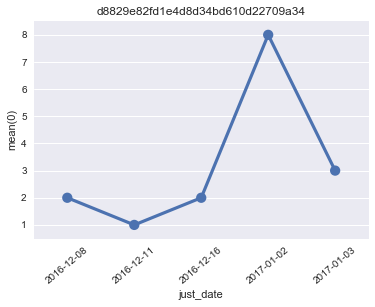

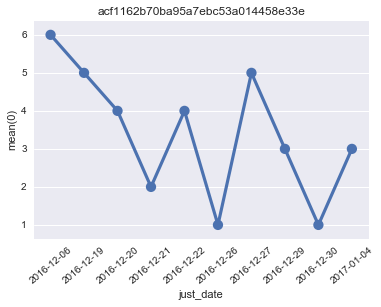

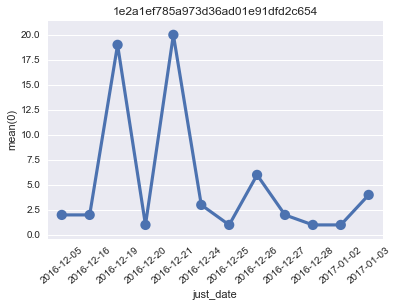

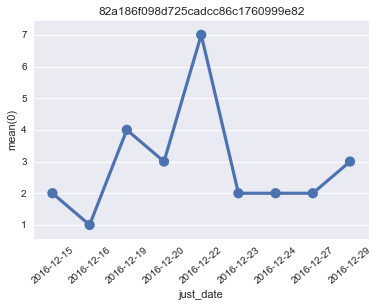

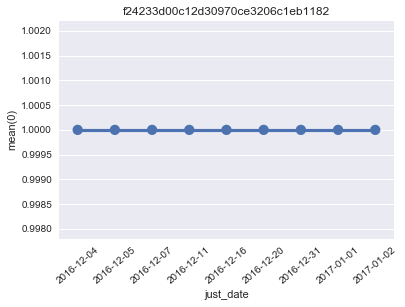

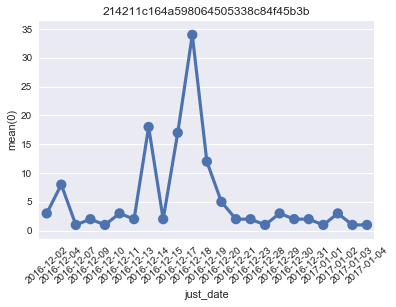

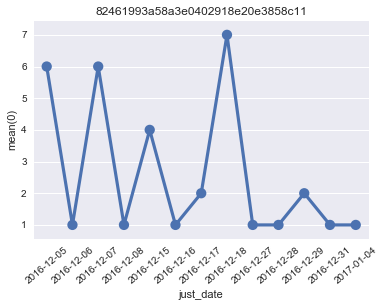

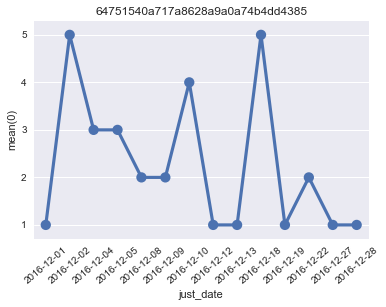

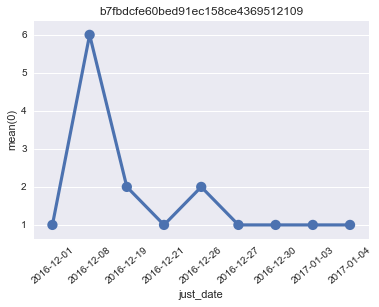

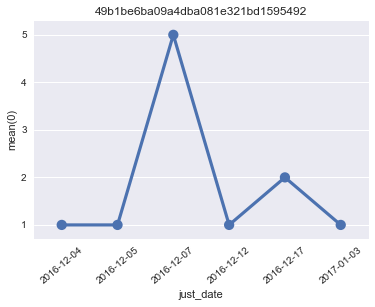

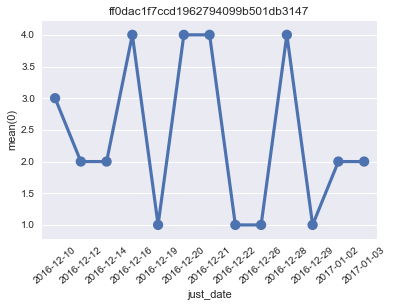

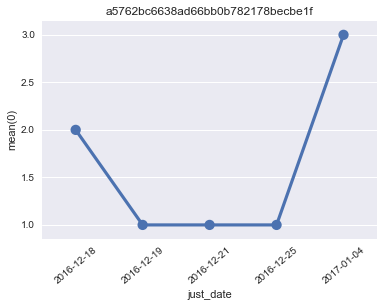

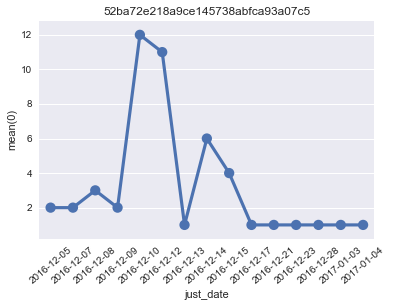

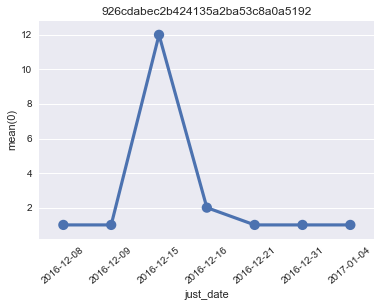

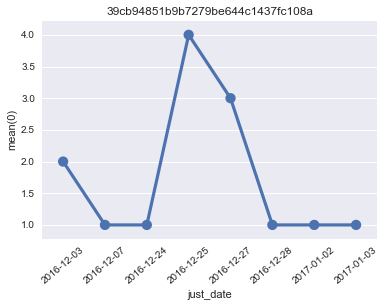

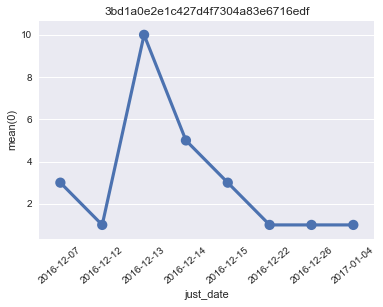

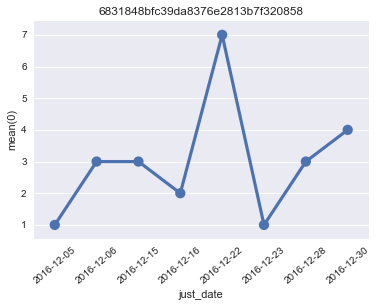

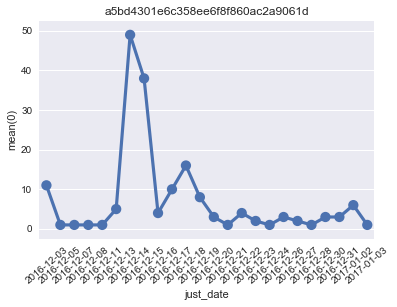

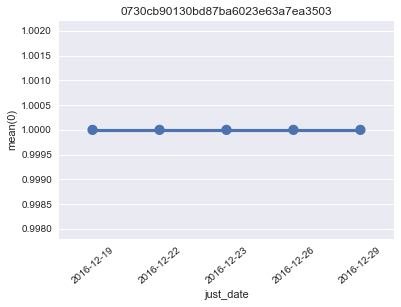

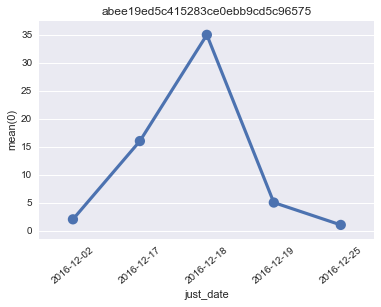

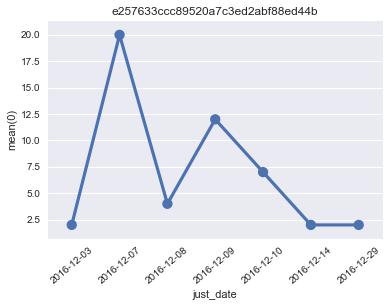

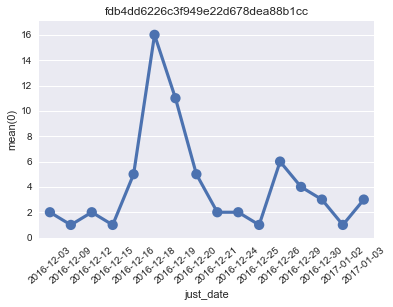

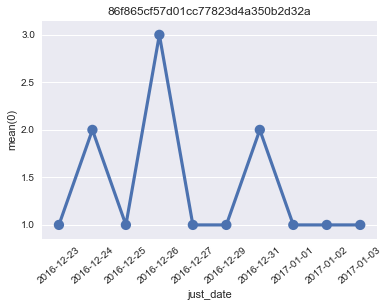

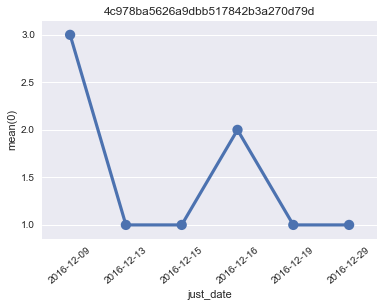

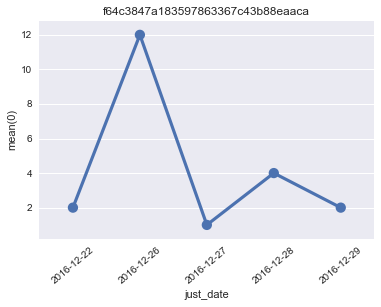

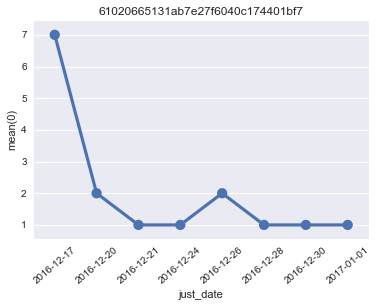

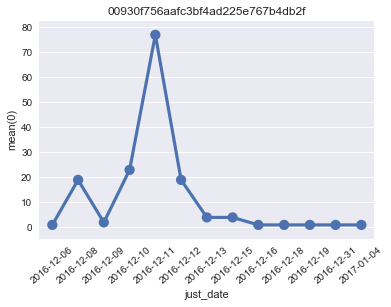

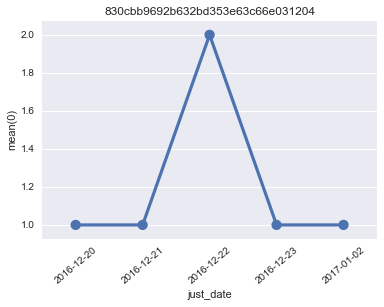

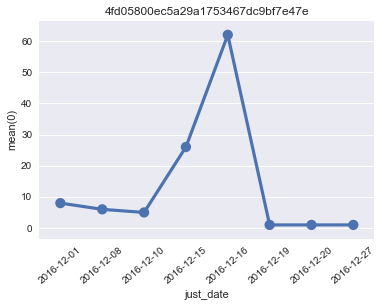

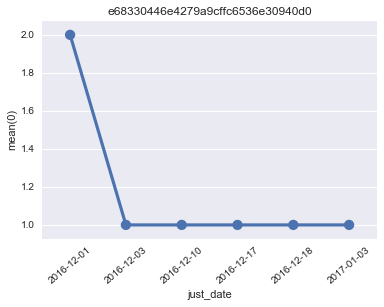

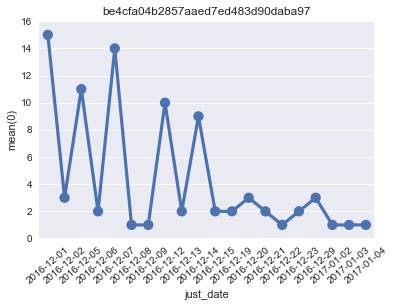

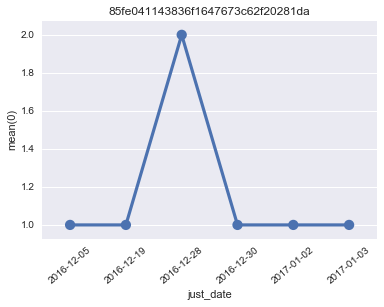

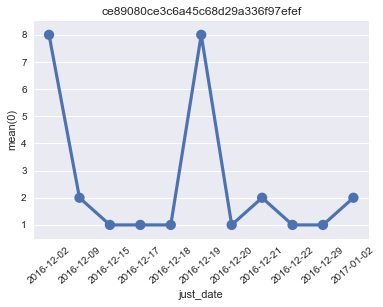

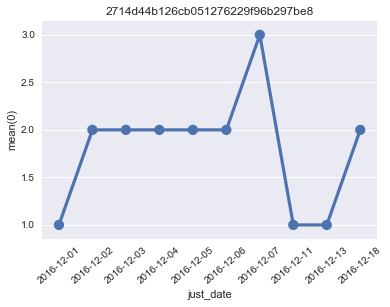

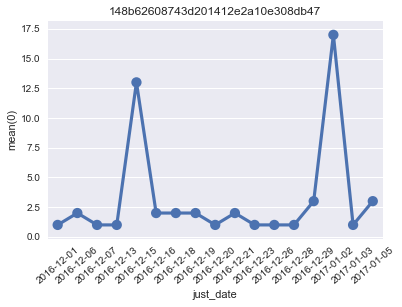

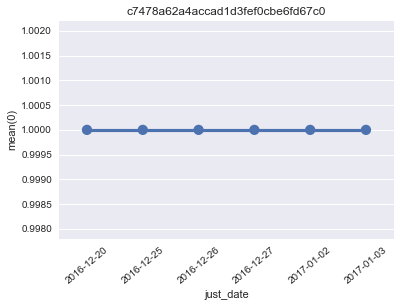

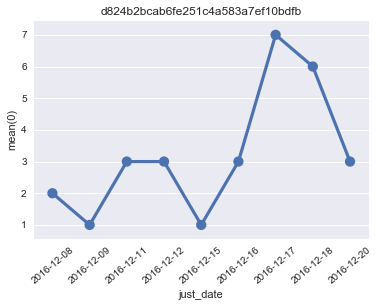

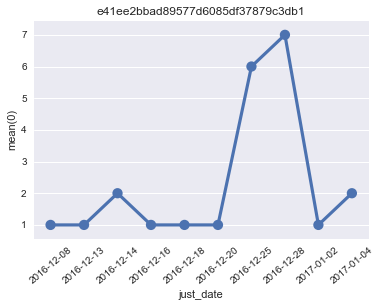

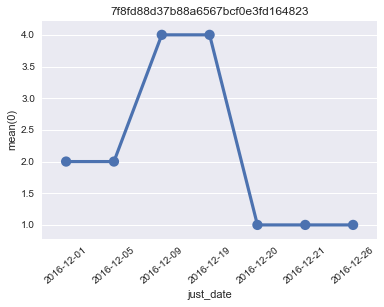

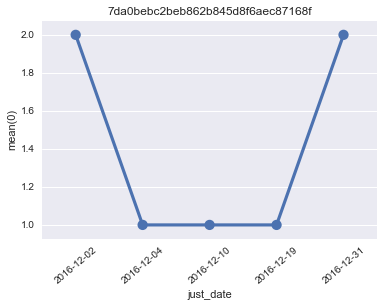

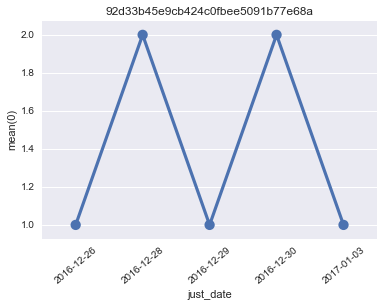

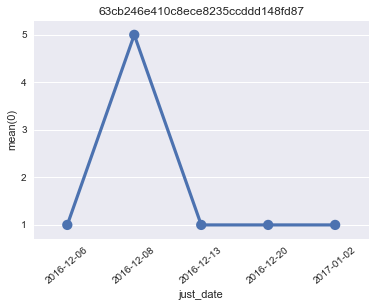

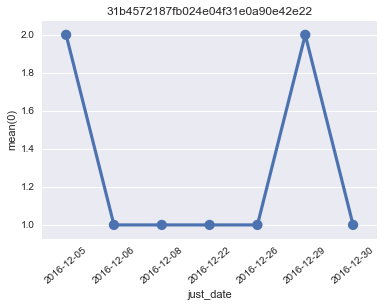

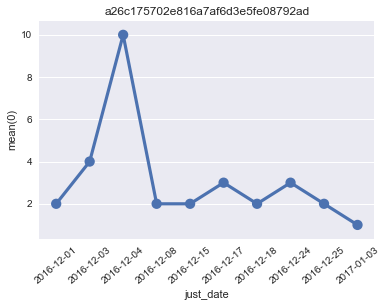

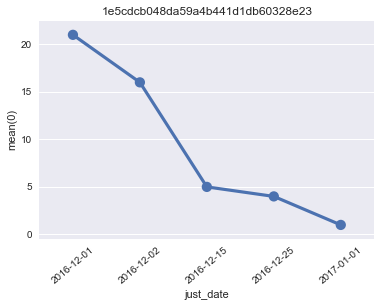

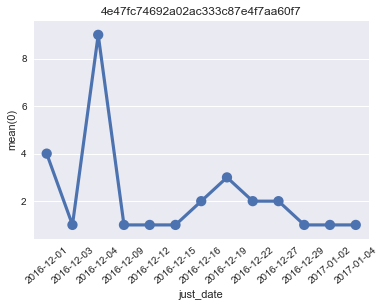

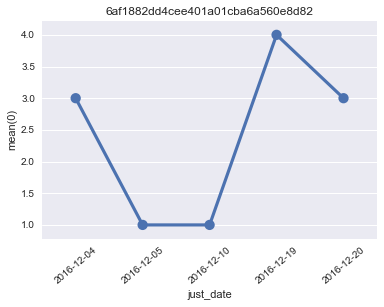

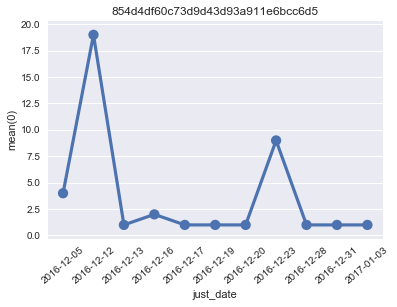

In [141]:
for i, nid in enumerate(filter_this):
    plt.figure(i)
    plt.xticks(rotation=40)
    ax.set_xlim(0, 80)
    sns.pointplot(x="just_date", y=0, data=more_than_5[more_than_5.networkidentifier==nid])
    sns.plt.title(nid)

# Indexing to KD/Ball Tree

In [142]:
all_data_ssid_dedup = filtered.drop_duplicates('networkidentifier')

In [143]:
all_data_ssid_dedup = all_data_ssid_dedup.drop(['eventtime','networktype','distance_from_centeroid', 'distance_from_centeroid_mean', 'absdiff', 'rmse'], axis=1)

In [144]:
all_data_ssid_dedup = all_data_ssid_dedup.reset_index(drop=True)

In [145]:
all_data_ssid_dedup.head();

In [146]:
def to_point(row):
    ltlg = s2sphere.LatLng.from_degrees(row[1], row[2])
    p = ltlg.to_point()
    return pd.Series([p[0], p[1], p[2]])
        
all_data_ssid_dedup[['x', 'y', 'z']] = all_data_ssid_dedup.apply(to_point, axis=1)

In [147]:
all_data_ssid_dedup.loc[:100];

In [148]:
X = all_data_ssid_dedup.drop(['accountid', 'networkidentifier', 'latitude_mean', 'longitude_mean', 'latitude', 'longitude'], axis=1)
Y = X.as_matrix()

In [149]:
tree = KDTree(Y) 

In [150]:
dist, ind = tree.query([Y[0]], k=1500) 
check_this = all_data_ssid_dedup.iloc[ind.tolist()[0]]


In [151]:
datafame_to_follium(check_this, 'latitude', 'longitude')

# Exploring data from map my india

In [166]:
sf = shapefile.Reader('/usr/share/India_Data/Karnataka/Poi_point')

In [167]:
shapes = sf.shapes()

In [171]:
len(shapes)

608511

In [286]:
for name in dir(shapes[3]):
    if not name.startswith('__'):
        print name

parts
points
shapeType


In [297]:
bangalore_box = box(77.32537600000006, 12.658149000000037, 77.83579600000007, 13.234974000000022)

In [305]:
shapes[3].points[0]

[77.67742400000003, 12.972961000000055]

In [302]:
points = []
for_follium = []
for shp in shapes:
    x = shp.points[0]
    p = point.Point(x[0], x[1])
    if p.within(bangalore_box):
        points.append(p)
        for_follium.append(x)

In [303]:
len(points)

290641

In [311]:
def datafame_to_follium_list(for_follium):
    lat = [x[1] for x in for_follium]
    lon = [x[0] for x in for_follium]
    latlon = zip(lat, lng)
    map_ = folium.Map( location=[lat[0],lng[0]], zoom_start=30 )
    is_first = True
    for coord in latlon:
        if is_first:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='red',icon='info-sign') ).add_to(map_)
            is_first=False
        else:
            folium.Marker( location=[ coord[0], coord[1] ], icon=folium.Icon(color='green',icon='ok-sign') ).add_to(map_)
    return map_

In [312]:
datafame_to_follium_list(for_follium)